In [158]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# SOM class

In [159]:
class SOM():
    def __init__(self, n, m, input_size, nbhd_fun_name='gaussian', nbhd_width=1.0, lr_decay_rate=0.1):
        self.size = (n, m)
        self.input_size = input_size
        self.weights = np.random.rand(n, m, input_size)
        self.nbhd_width = nbhd_width
        self._set_nbhd_fun(nbhd_fun_name)
        self.lr_decay_rate = lr_decay_rate
        self.lr_fun = lambda t: np.exp(-t / self.lr_decay_rate)

    def _set_nbhd_fun(self, nbhd_fun_name):
        """Set the neighborhood function based on the specified type."""
        if nbhd_fun_name == 'gaussian':
            self.nbhd_fun = lambda d: np.exp(- d ** 2 / (2 * self.nbhd_width))
        elif nbhd_fun_name == 'mexican_hat':
            self.nbhd_fun = lambda d: (1 - (d ** 2) / self.nbhd_width) * np.exp(- (d ** 2) / (2 * self.nbhd_width))
        else:
            raise ValueError("Unknown neighborhood function: {}".format(nbhd_fun_name))
    
    def find_bmu(self, x):
        """Find the Best Matching Unit (BMU) for the input x."""
        bmu_flat_idx = np.argmin(np.linalg.norm(self.weights - x, axis=2))
        bmu = np.unravel_index(bmu_flat_idx, self.size)
        return bmu
    
    def _update_weights(self, x, bmu, t):
        """Update the weights of the SOM."""
        learning_rate = self.lr_fun(t)
        for i in range(self.size[0]):
            for j in range(self.size[1]):
                d = np.linalg.norm(np.array(bmu) - np.array((i, j)))
                nbhd_weight = self.nbhd_fun(d)
                self.weights[i, j] += learning_rate * nbhd_weight * (x - self.weights[i, j])
        
    def fit(self, data, epochs=1000, n_display_epochs=100):
        """Train the SOM with the given data."""
        data = np.array(data)
        for t in range(epochs):
            if (t+1) % n_display_epochs == 0 or t == 0:
                print(f"Epoch {t+1}/{epochs}")
            shuffled_data = np.random.permutation(data)
            for x in shuffled_data:
                bmu = self.find_bmu(x)
                self._update_weights(x, bmu, t)

    def u_matrix(self):
        """Calculate the distance map of the SOM."""
        rows, cols = self.size
        u_matrix = np.zeros((self.size[0], self.size[1]))

        neighbor_offsets = [(-1, 0), (1, 0), (0, -1), (0, 1)]

        for i in range(rows):
            for j in range(cols):
                neighbor_distances = []
                for dx, dy in neighbor_offsets:
                    ni, nj = i + dx, j + dy
                    if 0 <= ni < rows and 0 <= nj < cols:
                        dist = np.linalg.norm(self.weights[i, j] - self.weights[ni, nj])
                        neighbor_distances.append(dist)
                u_matrix[i, j] = np.mean(neighbor_distances) if neighbor_distances else 0
        u_matrix = (u_matrix - np.min(u_matrix)) / (np.max(u_matrix) - np.min(u_matrix))

        return u_matrix

In [160]:
def find_n_clusters(som, max_k=10):
    """Find the optimal number of clusters using the elbow method."""
    scores = []
    weights = som.weights.reshape(-1, som.input_size)

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(weights)
        score = silhouette_score(weights, labels)
        scores.append(score)

    print("Best number of clusters:", np.argmax(scores) + 2)

In [161]:
def normalize(data, min = None, max = None):
    data = np.array(data)
    if min is None:
        min = np.min(data, axis=0)

    if max is None:
        max = np.max(data, axis=0)

    return (data - min) / (max - min), min, max    

In [162]:
def denormalize(data, min, max):
    data = np.array(data)
    return data * (max - min) + min

# Functions for visualization

In [163]:
def draw_u_matrix(som, X, Y):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    plot = ax[0].pcolor(som.u_matrix().T, cmap='gist_yarg')
    plt.colorbar(plot, ax=ax[0])
   
    markers = ['o', 's', 'D', '^', 'v', 'x', '+', '1', '2', '3', '4']
    colors = cm.get_cmap('viridis', len(np.unique(Y)))
    plot = ax[1].pcolor(som.u_matrix().T, cmap='gist_yarg', alpha=0.5)
    plt.colorbar(plot, ax=ax[1])

    for i in range(len(X)):
        bmu = som.find_bmu(X[i])
        ax[1].scatter(bmu[1] + 0.5, bmu[0] + 0.5, marker=markers[Y[i]], c=colors(Y[i]), s=100, label=f'Class {Y[i]}')

    ax[0].set_title('U-Matrix')

    plt.show()


In [164]:
def plot_som(som, X, Y):
    fig, ax = plt.subplots(figsize=(8, 7))
    ax.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis', s=10)
    ax.scatter(som.weights[:, :, 0].flatten(), som.weights[:, :, 1].flatten(), c='red', s=50, marker='x')
    ax.set_title('Input Data')
    plt.show()


In [165]:
def draw_neuron_comp(som, X, Y, n_lanbels):
    fig, ax = plt.subplots(2, n_lanbels//2, figsize=(6 * n_lanbels//2, 12))
    matrices = np.zeros((som.size[0], som.size[1], n_lanbels))
    for i in range(len(X)):
        bmu = som.find_bmu(X[i])
        matrices[bmu[0], bmu[1], Y[i]] += 1
    for i in range(n_lanbels):
        plot = ax[i // (n_lanbels//2), i % (n_lanbels//2)].pcolor(matrices[:, :, i], cmap='gist_yarg')
        plt.colorbar(plot, ax=ax[i // (n_lanbels//2), i % (n_lanbels//2)])
        ax[i // (n_lanbels//2), i % (n_lanbels//2)].set_title(f'Class {i}')


    plt.tight_layout()
    plt.show()

# hexagon

In [166]:
X = pd.read_csv('data/hexagon.csv')[['x', 'y']]
Y = pd.read_csv('data/hexagon.csv')['c']

In [167]:
X_norm, min, max = normalize(X)

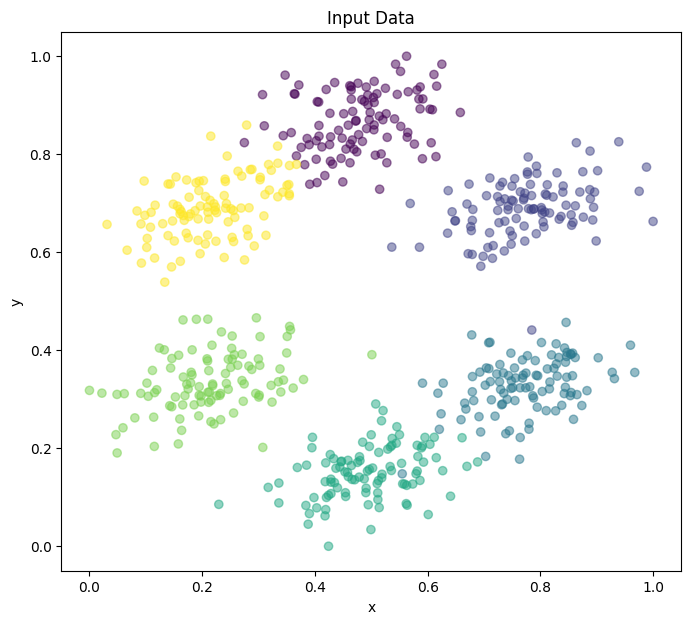

In [168]:
fig, ax = plt.subplots(figsize=(8, 7))
ax.scatter(X_norm[:, 0], X_norm[:, 1], c=Y, cmap='viridis', alpha=0.5)
plt.title('Input Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [169]:
nbhd_funcs = ['gaussian', 'mexican_hat']
nbhd_widths = [0.1, 0.5, 1.0, 2.0, 10]
lr_decay_rate = 1000
input_size = 2

## gaussian

Epoch 1/100
Epoch 10/100
Epoch 20/100
Epoch 30/100
Epoch 40/100
Epoch 50/100
Epoch 60/100
Epoch 70/100
Epoch 80/100
Epoch 90/100
Epoch 100/100


C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', len(np.unique(Y)))
C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(bmu[1] + 0.5, bmu[0] + 0.5, marker=markers[Y[i]], c=colors(Y[i]), s=100, label=f'Class {Y[i]}')


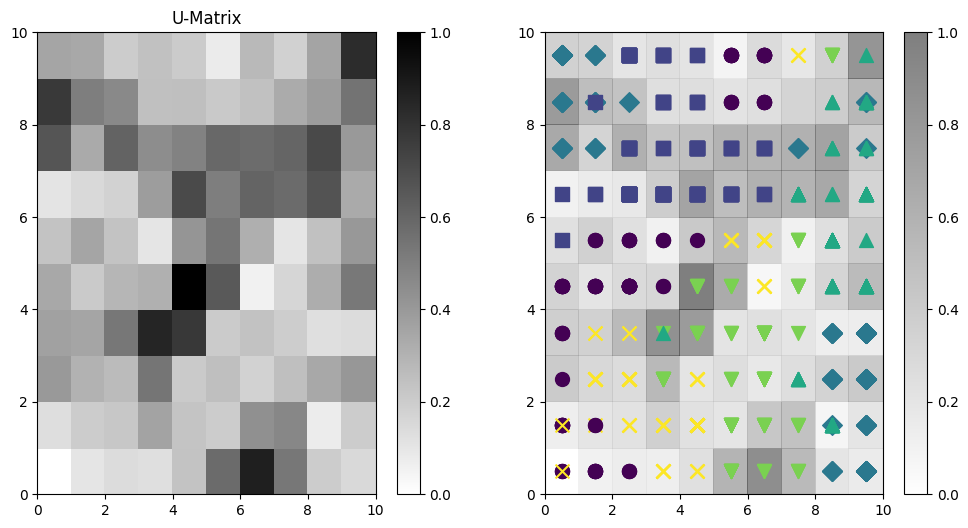

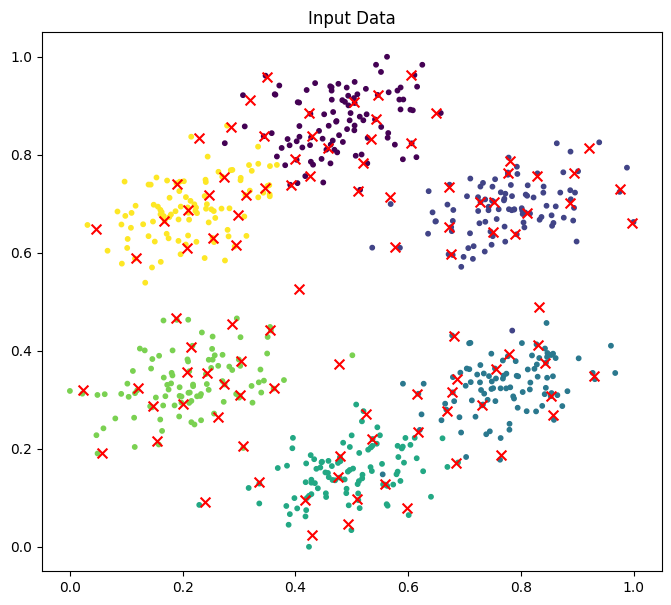

Best number of clusters: 6


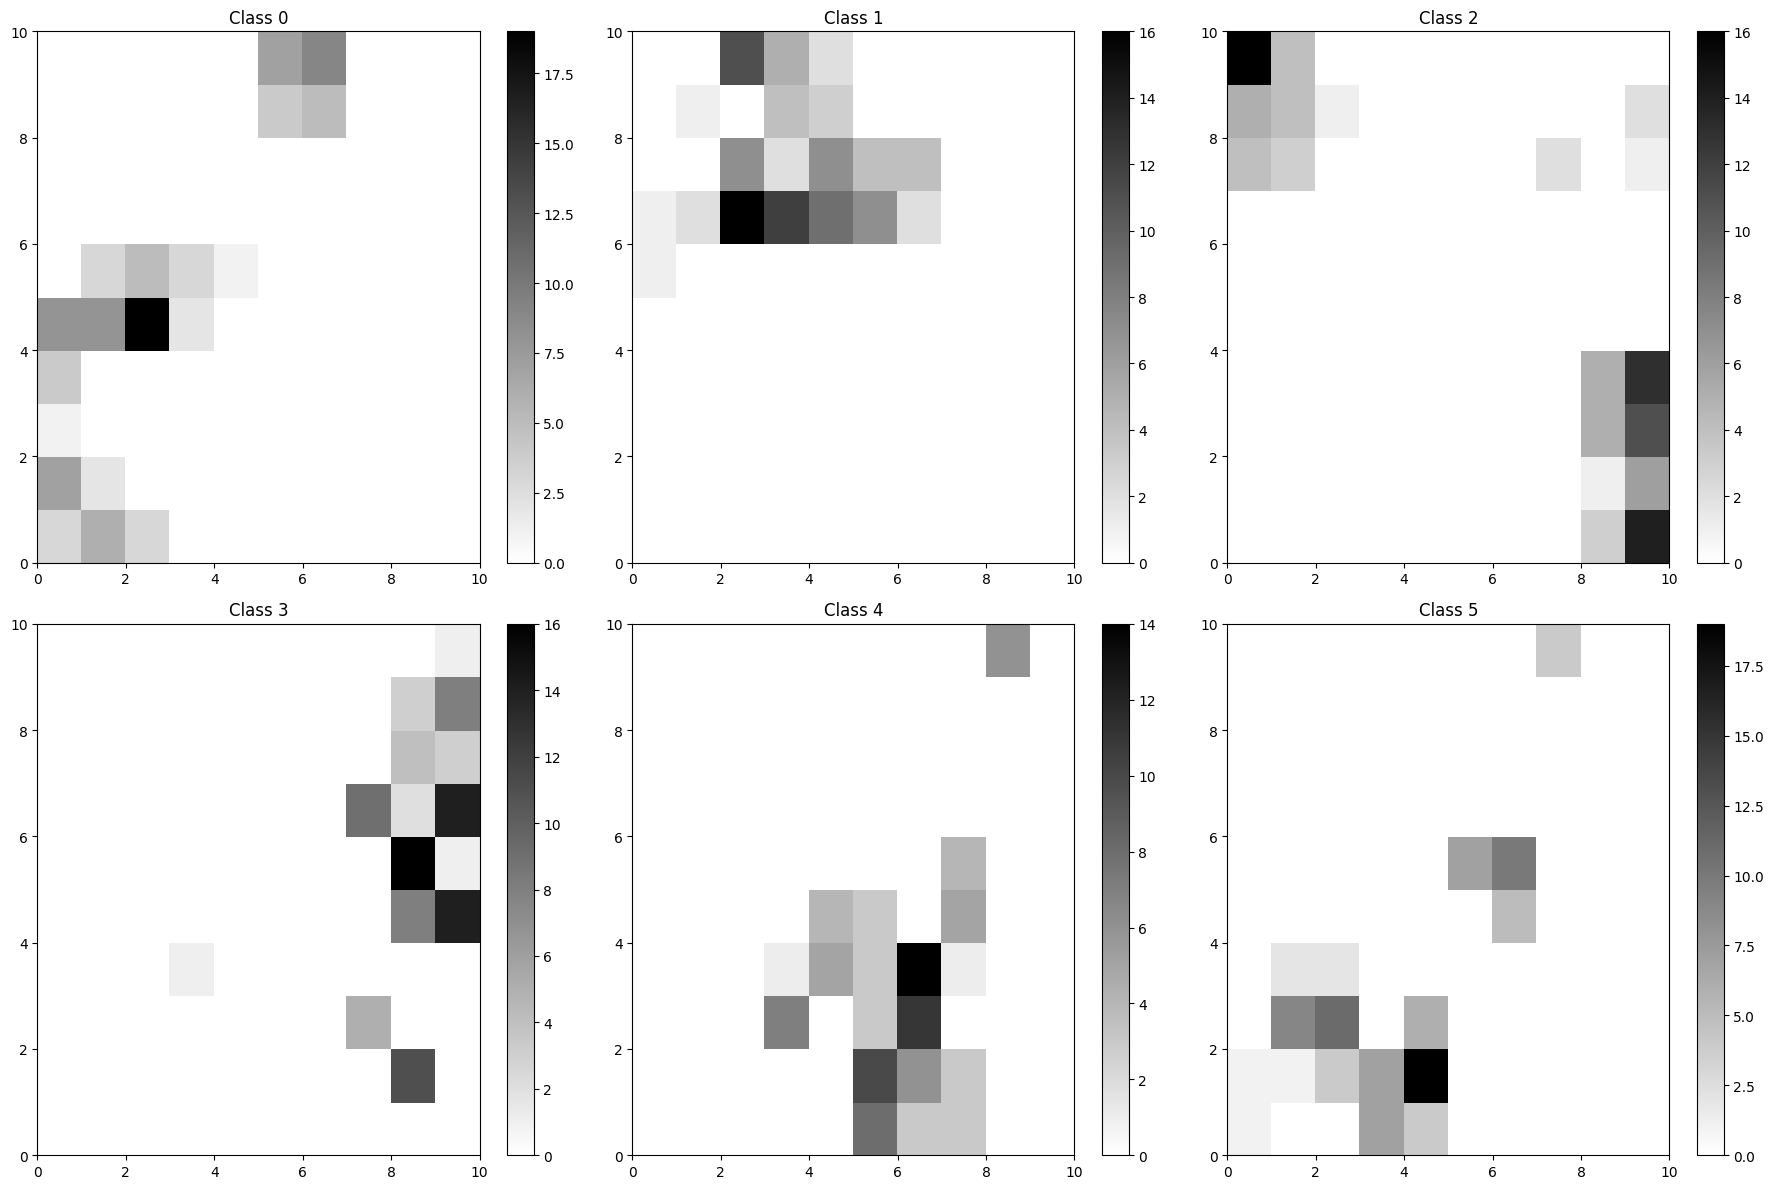

In [170]:
som = SOM(10, 10, 2, nbhd_fun_name='gaussian', nbhd_width=0.1, lr_decay_rate=1000)
som.fit(X_norm, epochs=100, n_display_epochs=10)
draw_u_matrix(som, X_norm, Y)
plot_som(som, X_norm, Y)
find_n_clusters(som, max_k=10)
draw_neuron_comp(som, X_norm, Y, n_lanbels=6)

Epoch 1/100
Epoch 10/100
Epoch 20/100
Epoch 30/100
Epoch 40/100
Epoch 50/100
Epoch 60/100
Epoch 70/100
Epoch 80/100
Epoch 90/100
Epoch 100/100


C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', len(np.unique(Y)))
C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(bmu[1] + 0.5, bmu[0] + 0.5, marker=markers[Y[i]], c=colors(Y[i]), s=100, label=f'Class {Y[i]}')


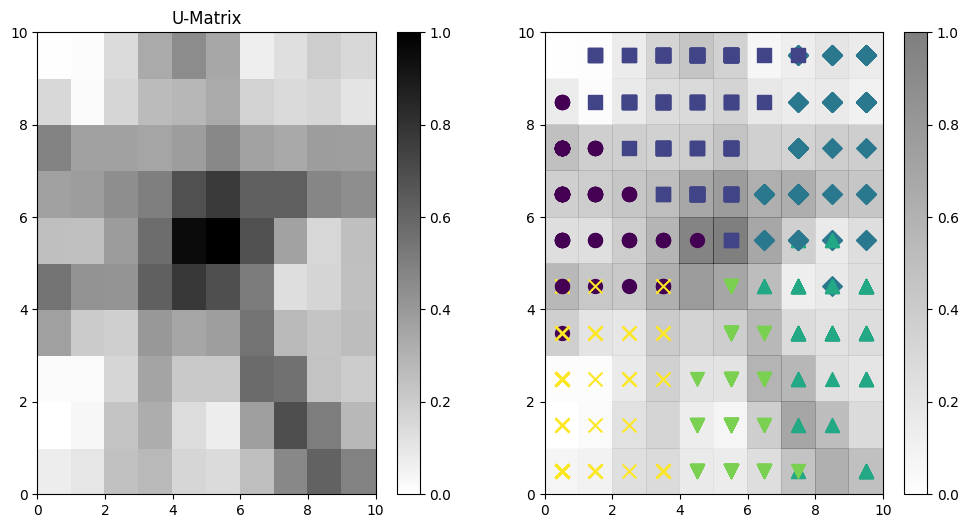

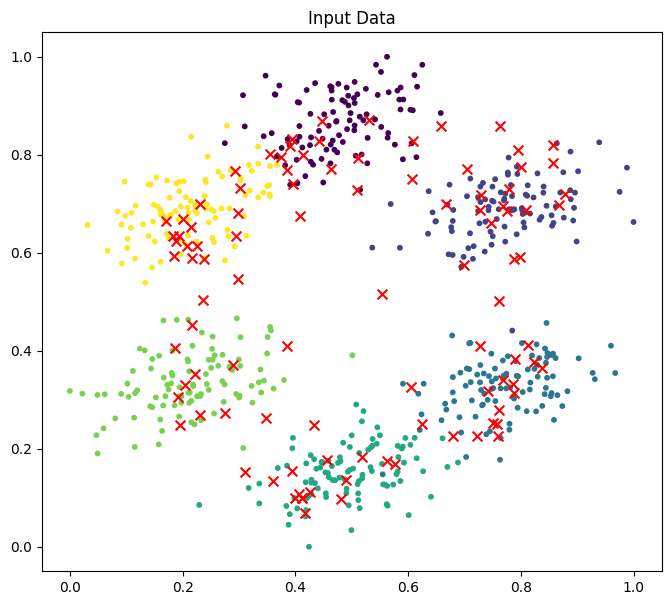

Best number of clusters: 6


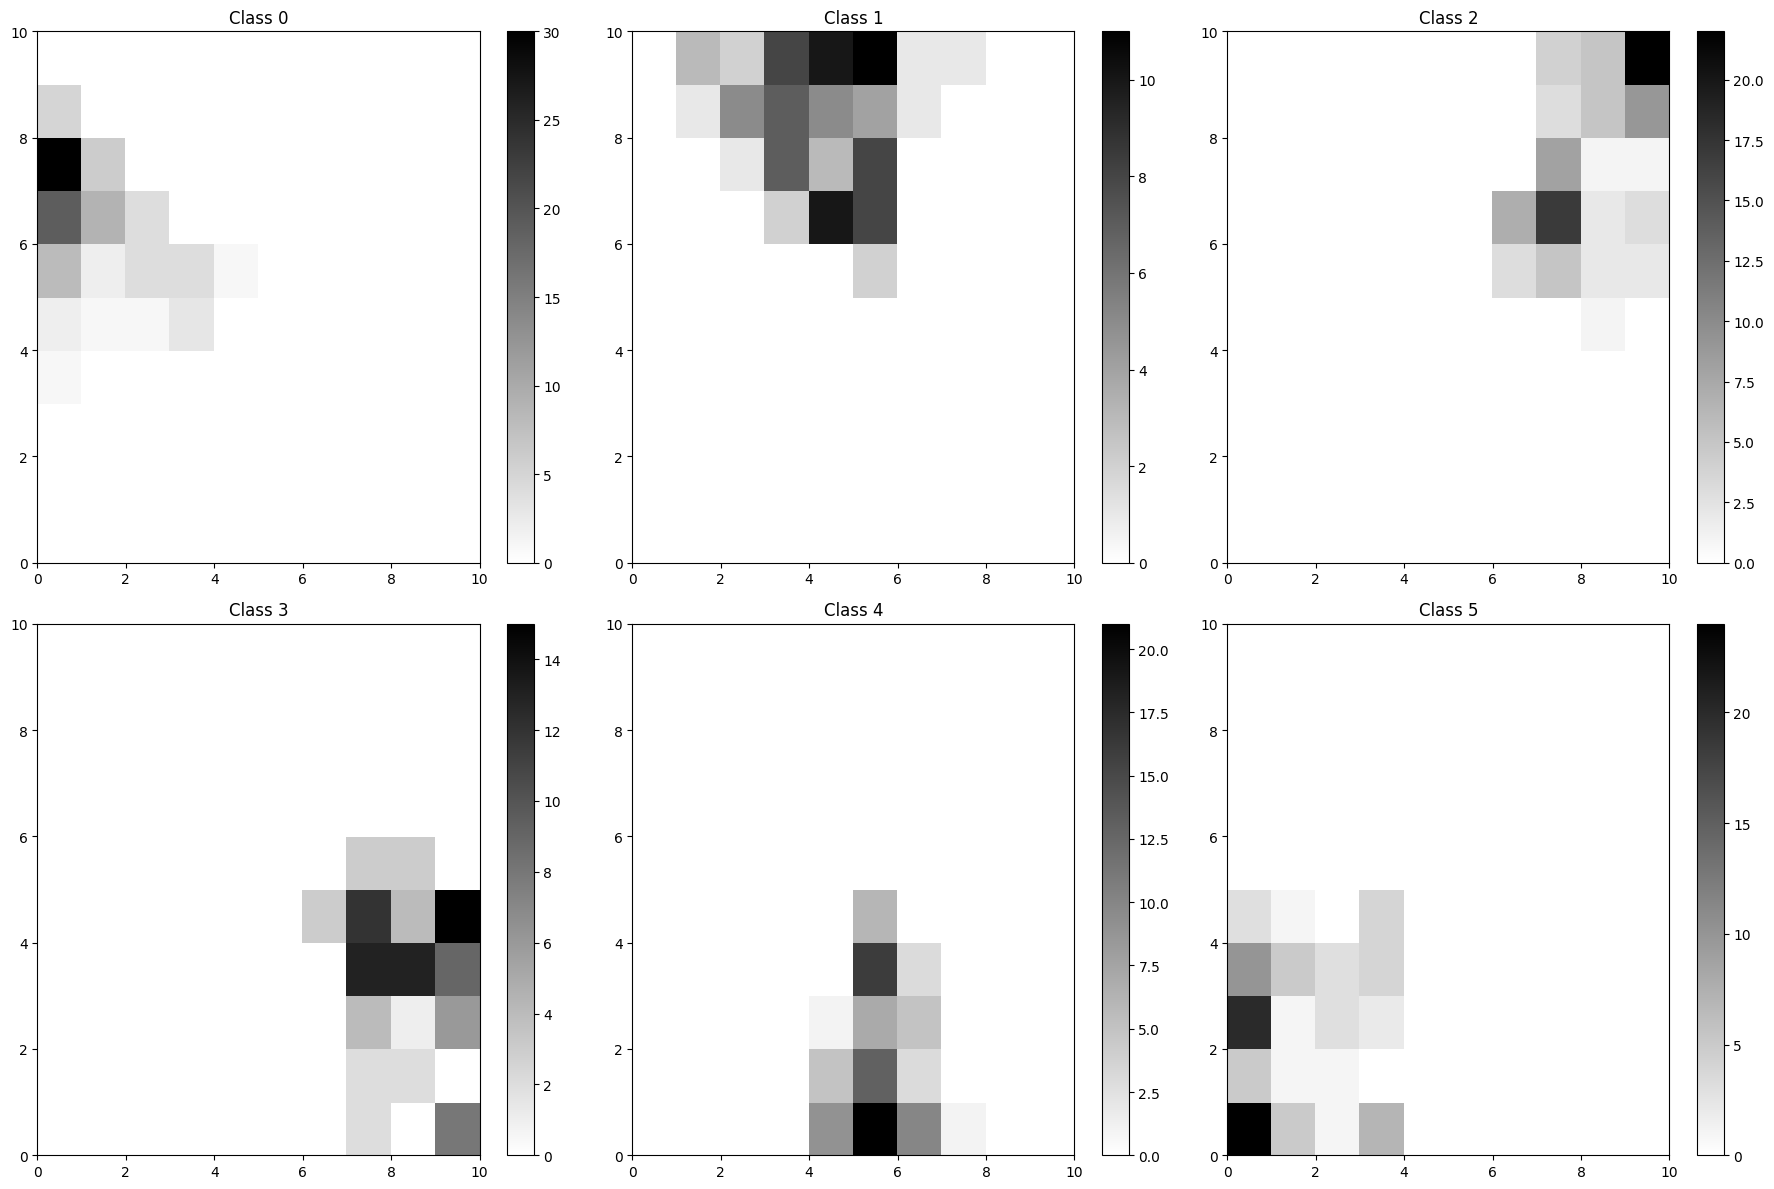

In [171]:
som = SOM(10, 10, 2, nbhd_fun_name='gaussian', nbhd_width=1, lr_decay_rate=1000)
som.fit(X_norm, epochs=100, n_display_epochs=10)
draw_u_matrix(som, X_norm, Y)
plot_som(som, X_norm, Y)
find_n_clusters(som, max_k=10)
draw_neuron_comp(som, X_norm, Y, n_lanbels=6)

Epoch 1/100
Epoch 10/100
Epoch 20/100
Epoch 30/100
Epoch 40/100
Epoch 50/100
Epoch 60/100
Epoch 70/100
Epoch 80/100
Epoch 90/100
Epoch 100/100


C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', len(np.unique(Y)))
C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(bmu[1] + 0.5, bmu[0] + 0.5, marker=markers[Y[i]], c=colors(Y[i]), s=100, label=f'Class {Y[i]}')


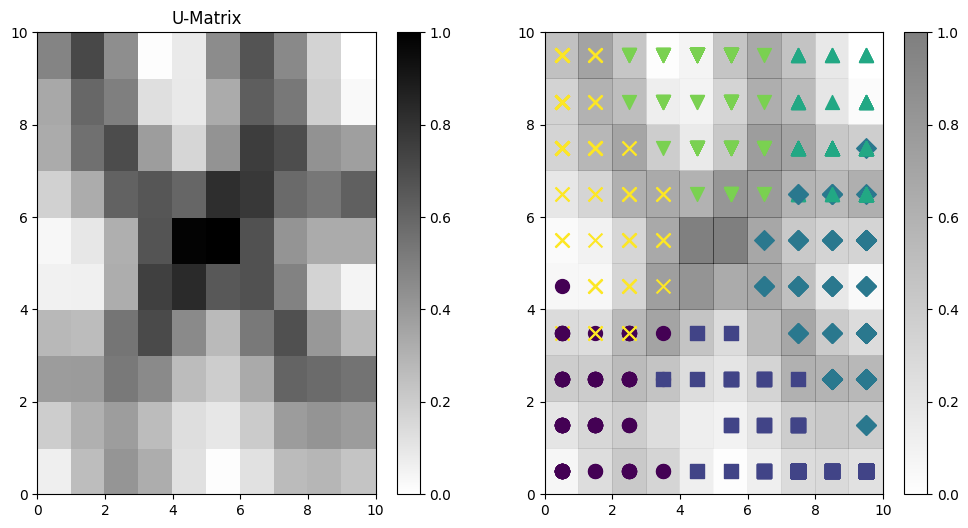

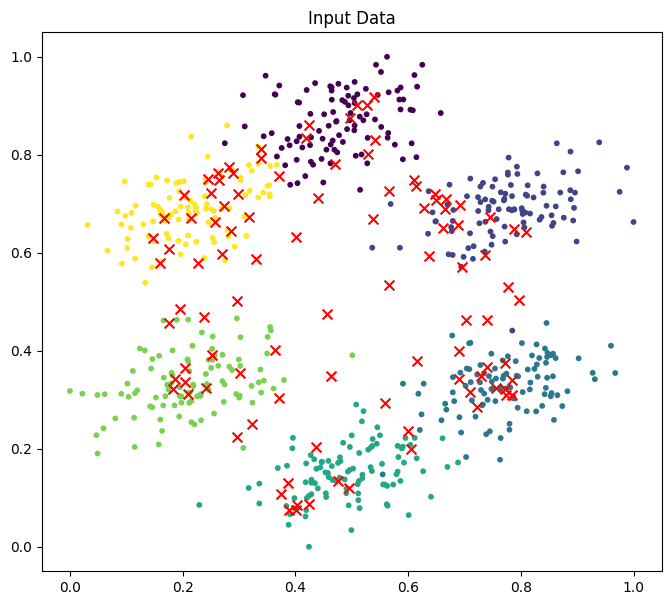

Best number of clusters: 6


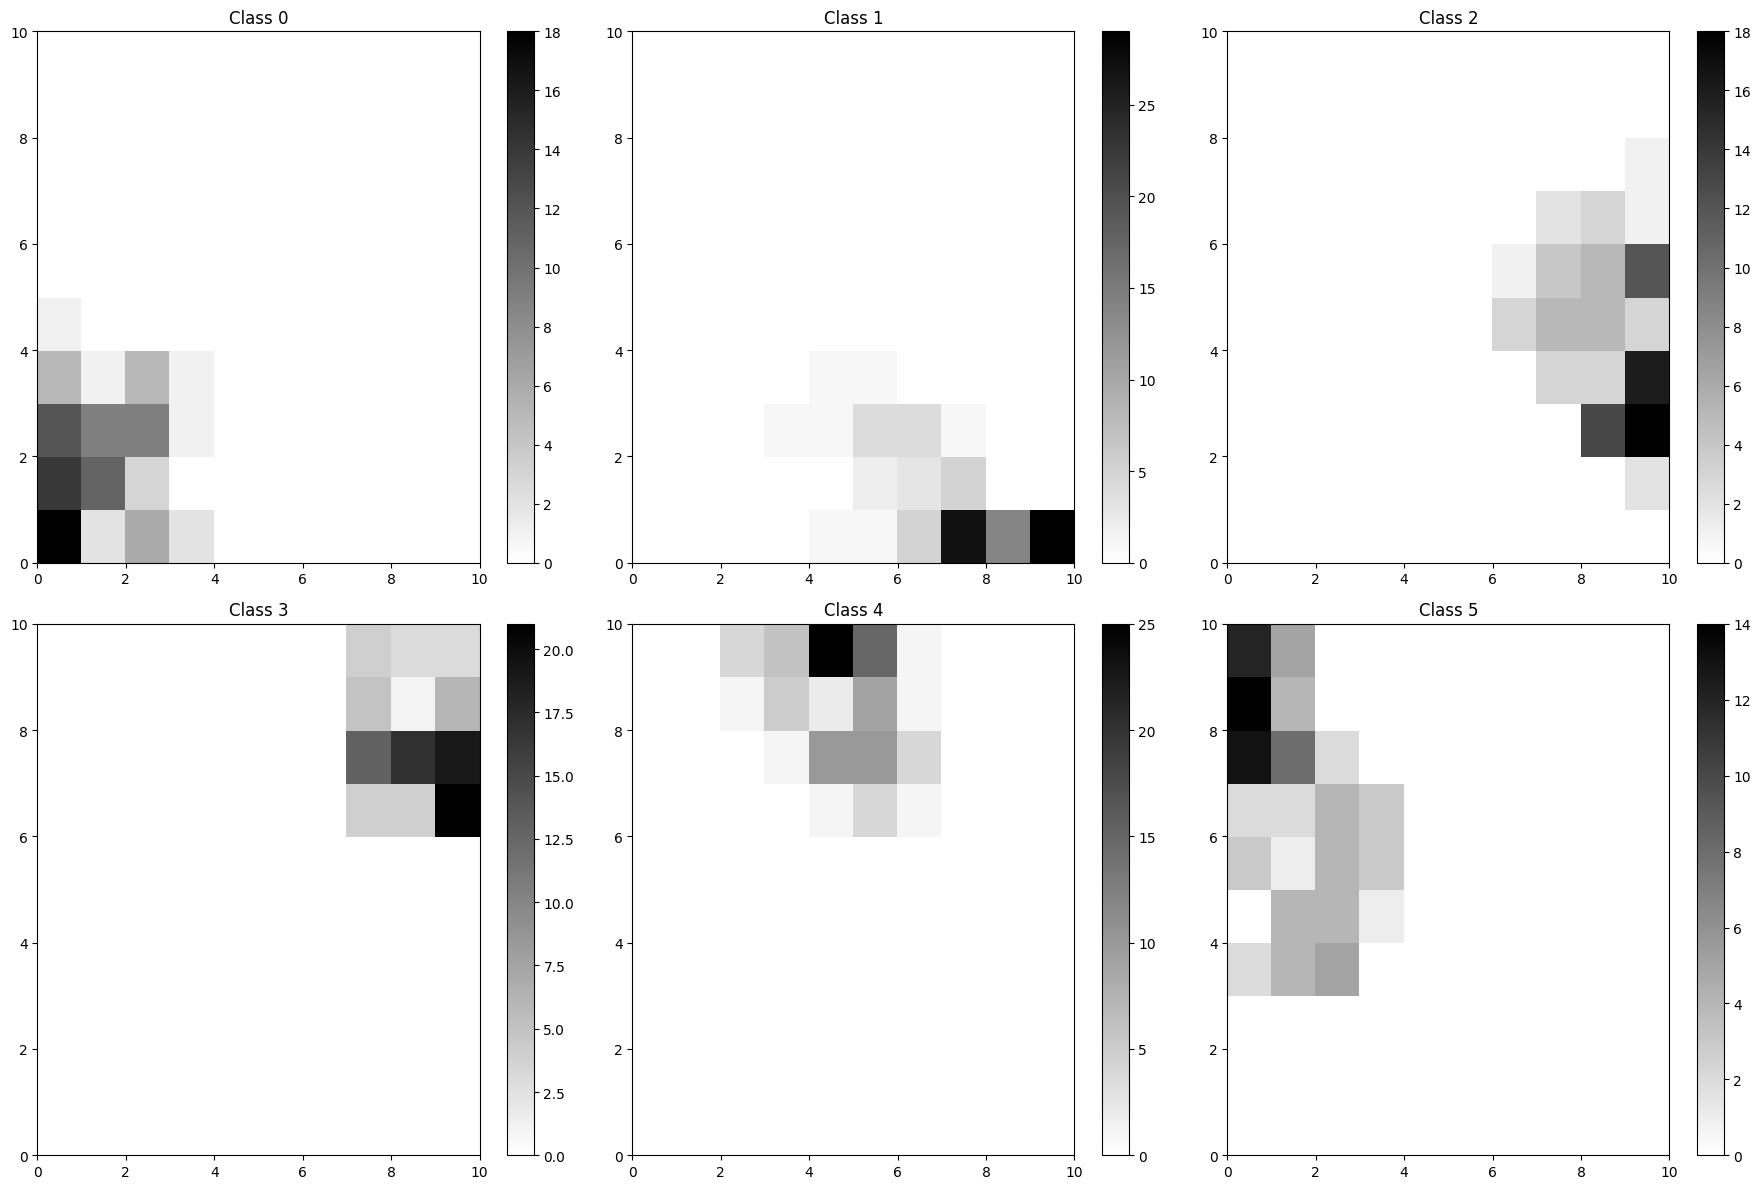

In [172]:
som = SOM(10, 10, 2, nbhd_fun_name='gaussian', nbhd_width=2, lr_decay_rate=1000)
som.fit(X_norm, epochs=100, n_display_epochs=10)
draw_u_matrix(som, X_norm, Y)
plot_som(som, X_norm, Y)
find_n_clusters(som, max_k=10)
draw_neuron_comp(som, X_norm, Y, n_lanbels=6)

Epoch 1/100
Epoch 10/100
Epoch 20/100
Epoch 30/100
Epoch 40/100
Epoch 50/100
Epoch 60/100
Epoch 70/100
Epoch 80/100
Epoch 90/100
Epoch 100/100


C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', len(np.unique(Y)))
C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(bmu[1] + 0.5, bmu[0] + 0.5, marker=markers[Y[i]], c=colors(Y[i]), s=100, label=f'Class {Y[i]}')


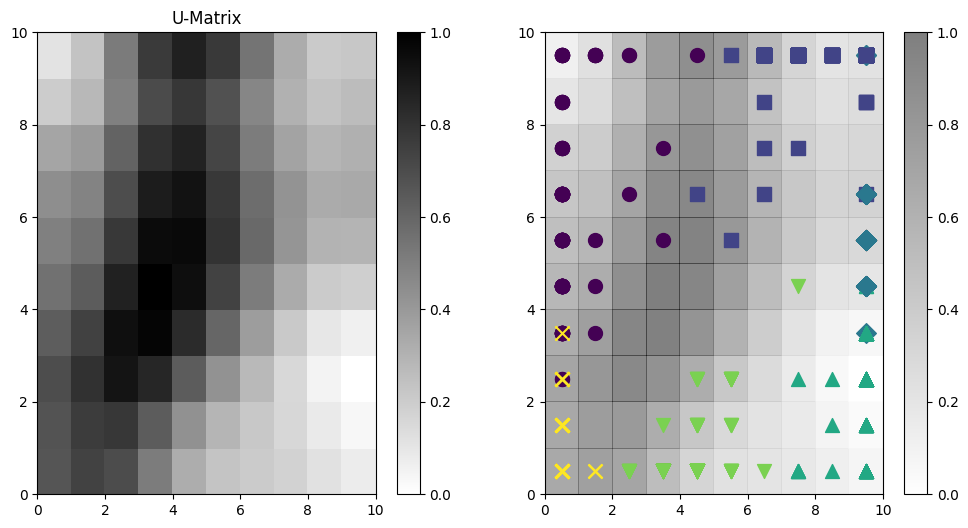

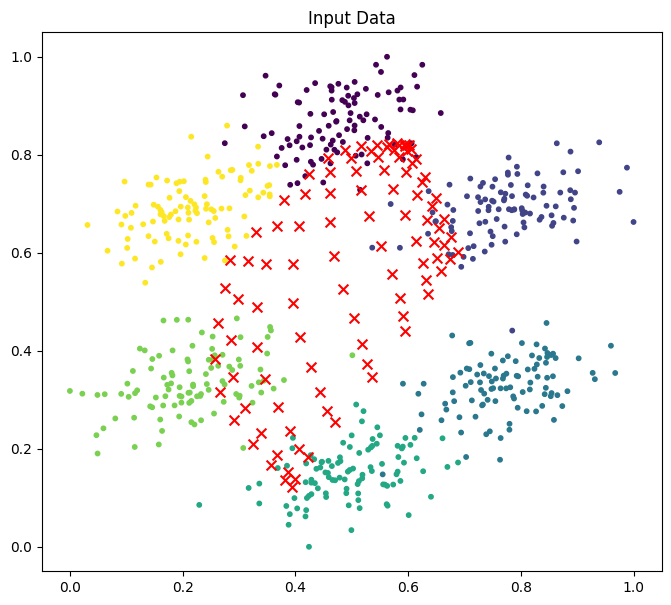

Best number of clusters: 2


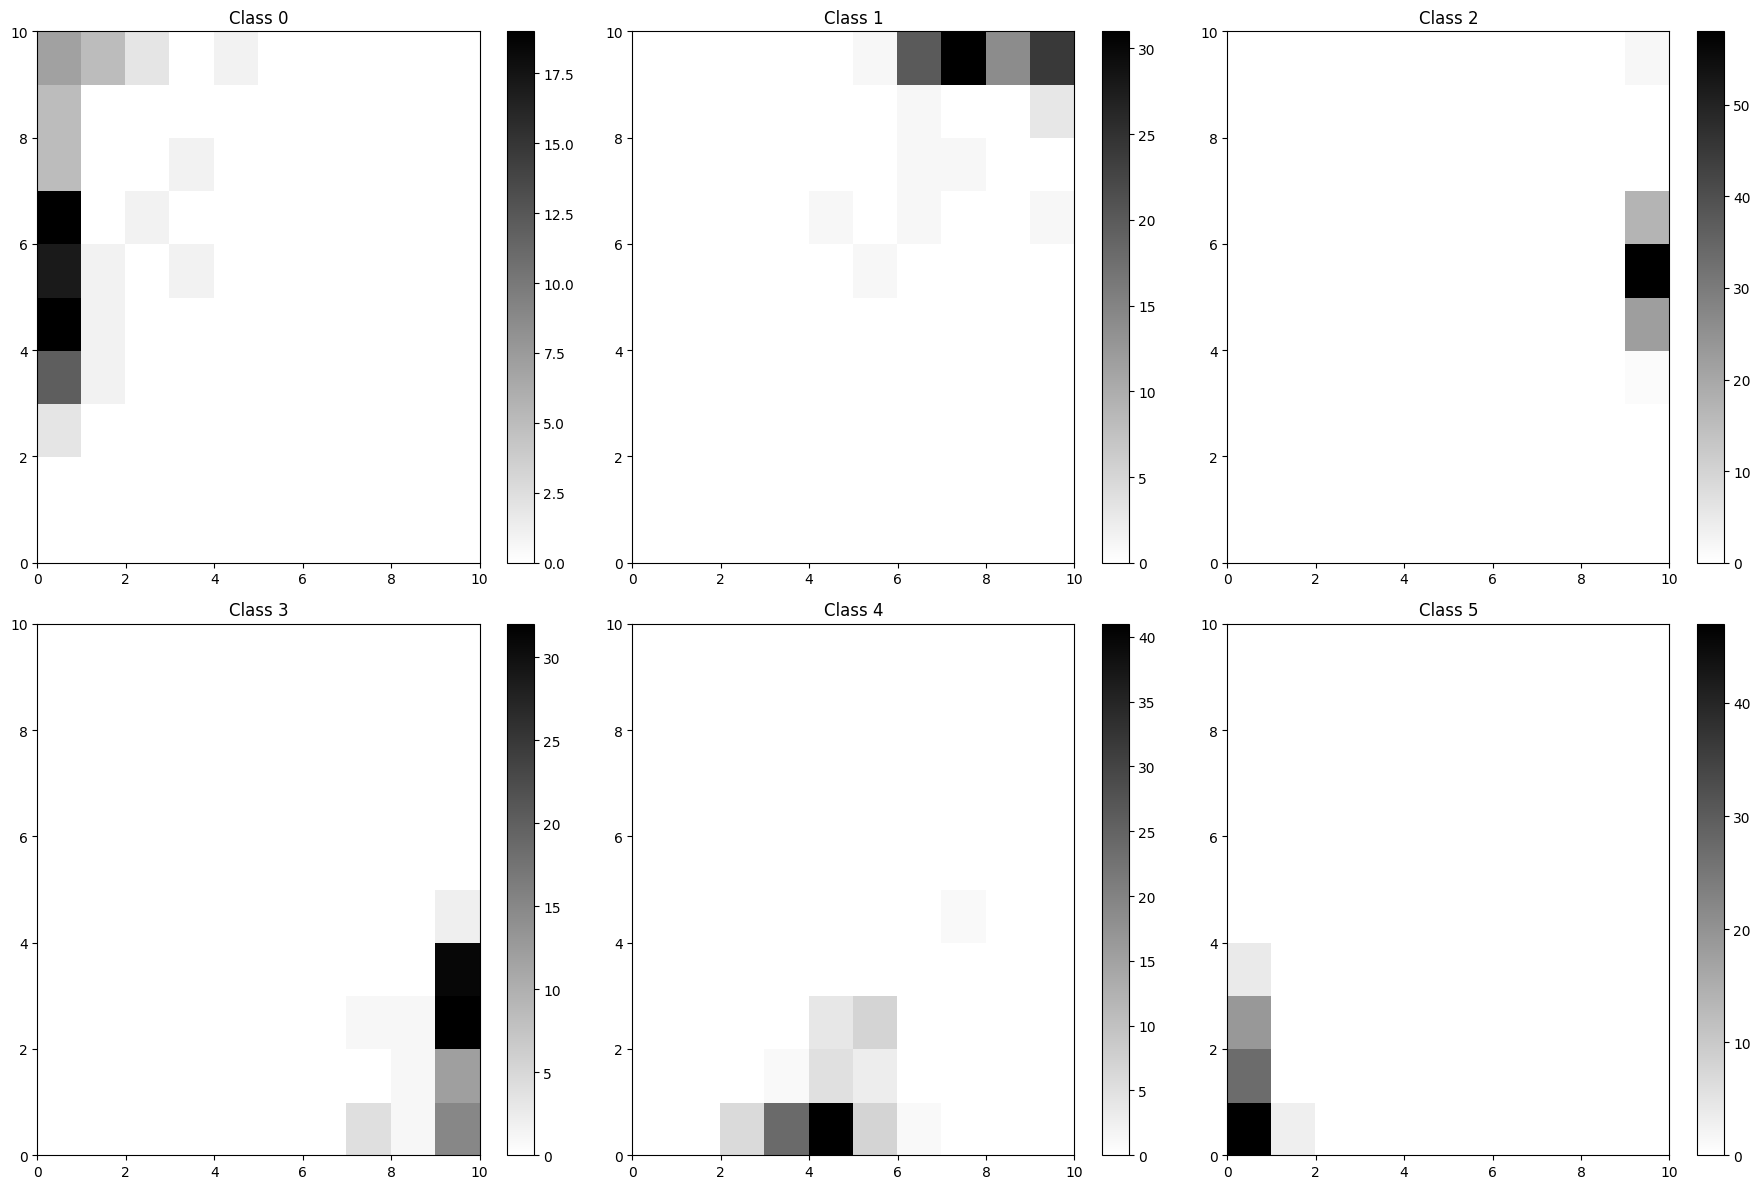

In [173]:
som = SOM(10, 10, 2, nbhd_fun_name='gaussian', nbhd_width=10, lr_decay_rate=1000)
som.fit(X_norm, epochs=100, n_display_epochs=10)
draw_u_matrix(som, X_norm, Y)
plot_som(som, X_norm, Y)
find_n_clusters(som, max_k=10)
draw_neuron_comp(som, X_norm, Y, n_lanbels=6)

## mexican_hat

Epoch 1/10


c:\Users\kuba_\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\linalg\linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
c:\Users\kuba_\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\linalg\linalg.py:2583: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\3577833075.py:33: RuntimeWarning: overflow encountered in add
  self.weights[i, j] += learning_rate * nbhd_weight * (x - self.weights[i, j])
C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\3577833075.py:33: RuntimeWarning: invalid value encountered in add
  self.weights[i, j] += learning_rate * nbhd_weight * (x - self.weights[i, j])


Epoch 10/10


C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\3577833075.py:59: RuntimeWarning: invalid value encountered in subtract
  dist = np.linalg.norm(self.weights[i, j] - self.weights[ni, nj])
C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', len(np.unique(Y)))
C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(bmu[1] + 0.5, bmu[0] + 0.5, marker=markers[Y[i]], c=col

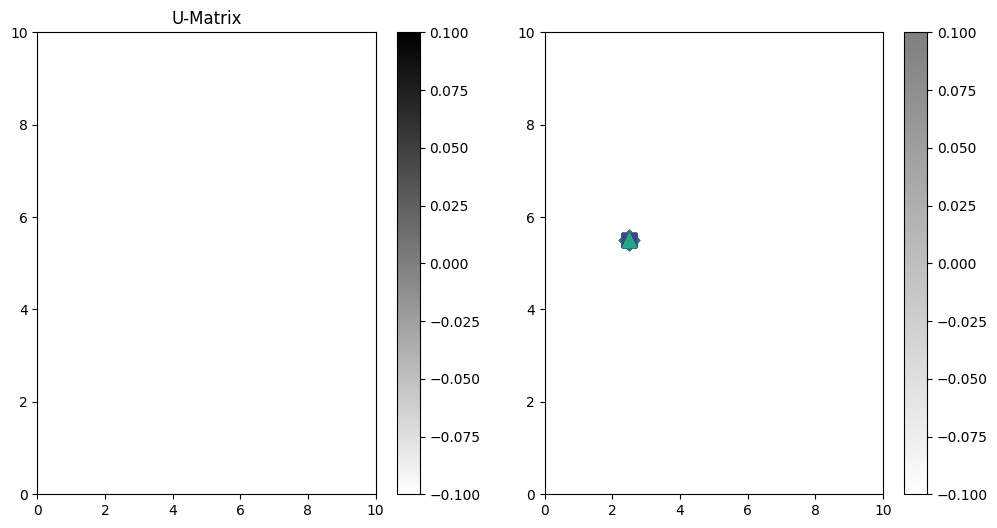

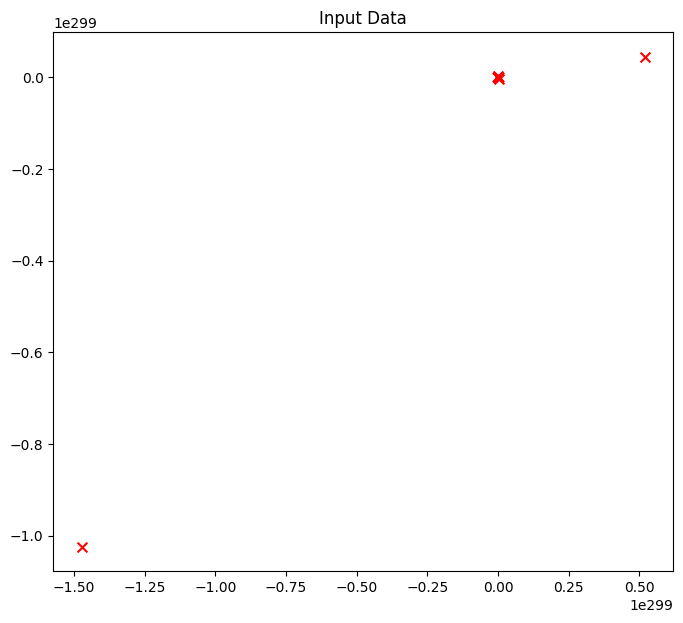

In [175]:
som = SOM(10, 10, 2, nbhd_fun_name='mexican_hat', nbhd_width=5, lr_decay_rate=1000)
som.fit(X_norm, epochs=10, n_display_epochs=10)
draw_u_matrix(som, X_norm, Y)
plot_som(som, X_norm, Y)

## Grid size comparison

Epoch 1/100
Epoch 10/100
Epoch 20/100
Epoch 30/100
Epoch 40/100
Epoch 50/100
Epoch 60/100
Epoch 70/100
Epoch 80/100
Epoch 90/100
Epoch 100/100


C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', len(np.unique(Y)))
C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(bmu[1] + 0.5, bmu[0] + 0.5, marker=markers[Y[i]], c=colors(Y[i]), s=100, label=f'Class {Y[i]}')


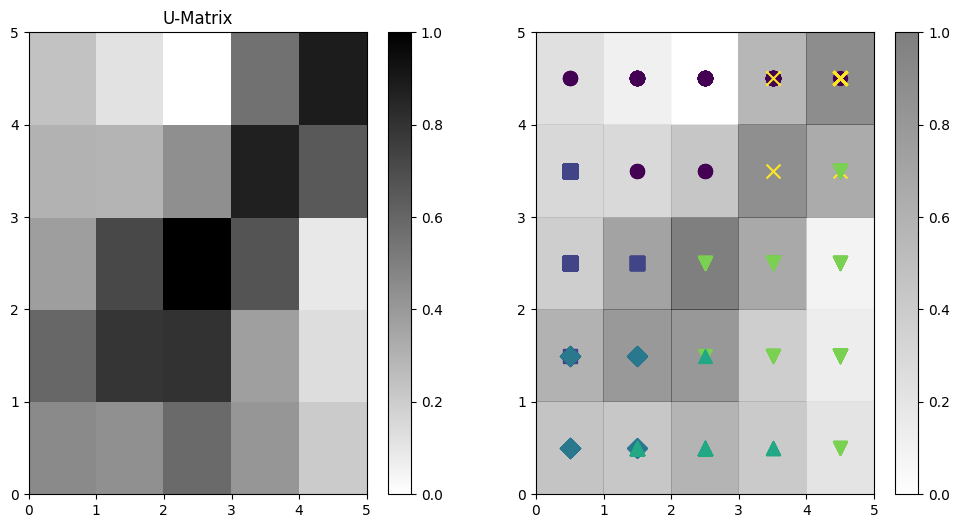

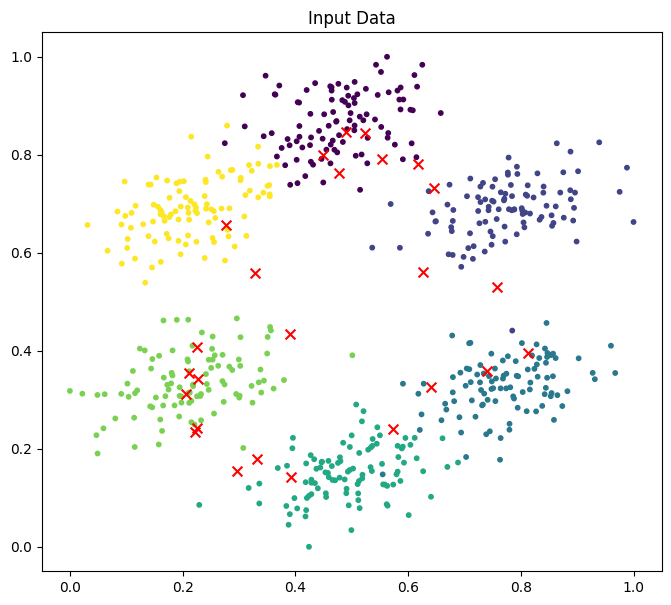

Best number of clusters: 3


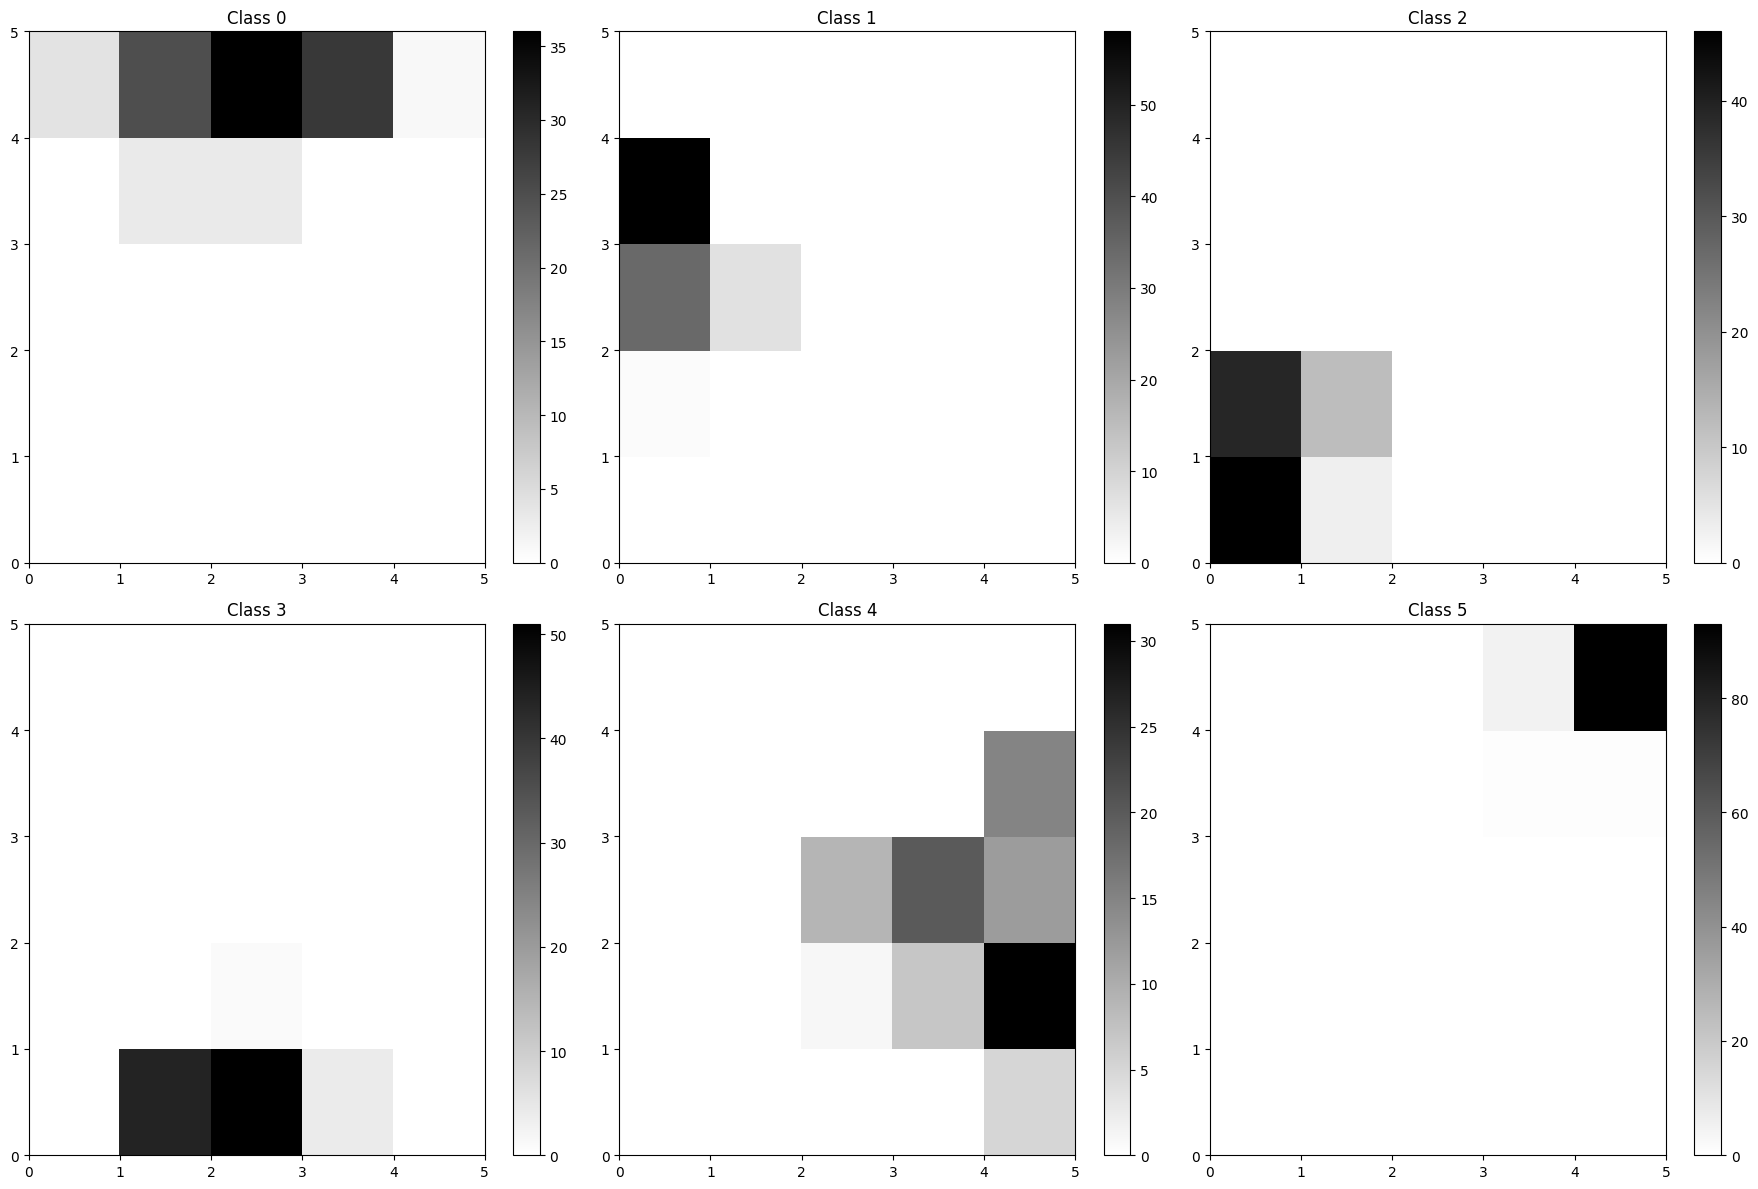

In [179]:
som = SOM(5, 5, 2, nbhd_fun_name='gaussian', nbhd_width=1, lr_decay_rate=1000)
som.fit(X_norm, epochs=100, n_display_epochs=10)
draw_u_matrix(som, X_norm, Y)
plot_som(som, X_norm, Y)
find_n_clusters(som, max_k=10)
draw_neuron_comp(som, X_norm, Y, n_lanbels=6)

Epoch 1/100
Epoch 10/100
Epoch 20/100
Epoch 30/100
Epoch 40/100
Epoch 50/100
Epoch 60/100
Epoch 70/100
Epoch 80/100
Epoch 90/100
Epoch 100/100


C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', len(np.unique(Y)))
C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(bmu[1] + 0.5, bmu[0] + 0.5, marker=markers[Y[i]], c=colors(Y[i]), s=100, label=f'Class {Y[i]}')


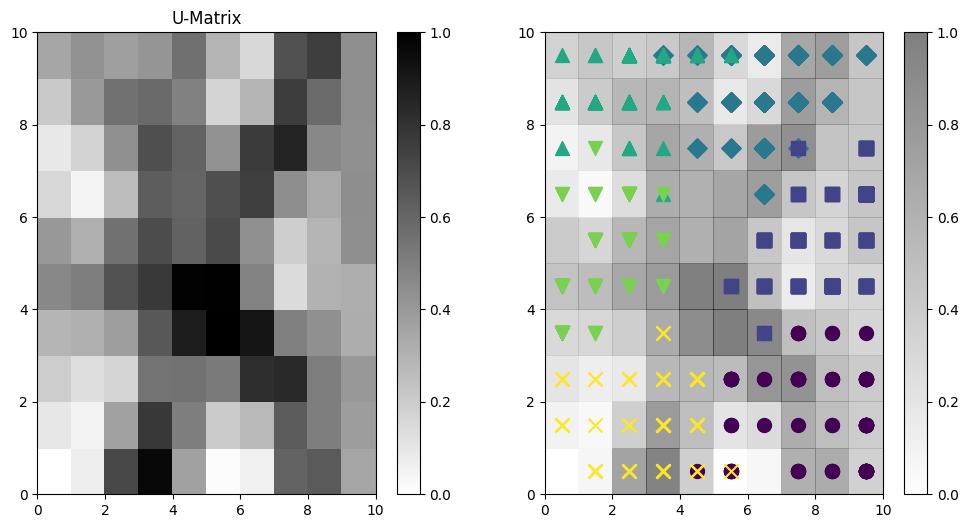

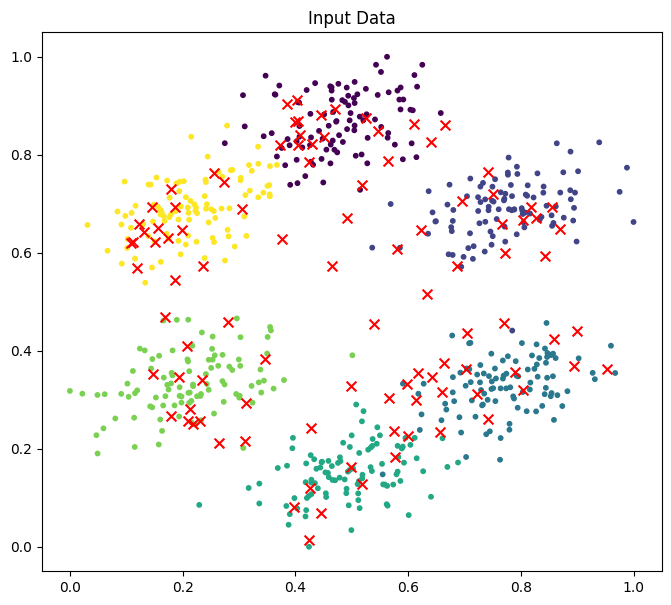

Best number of clusters: 5


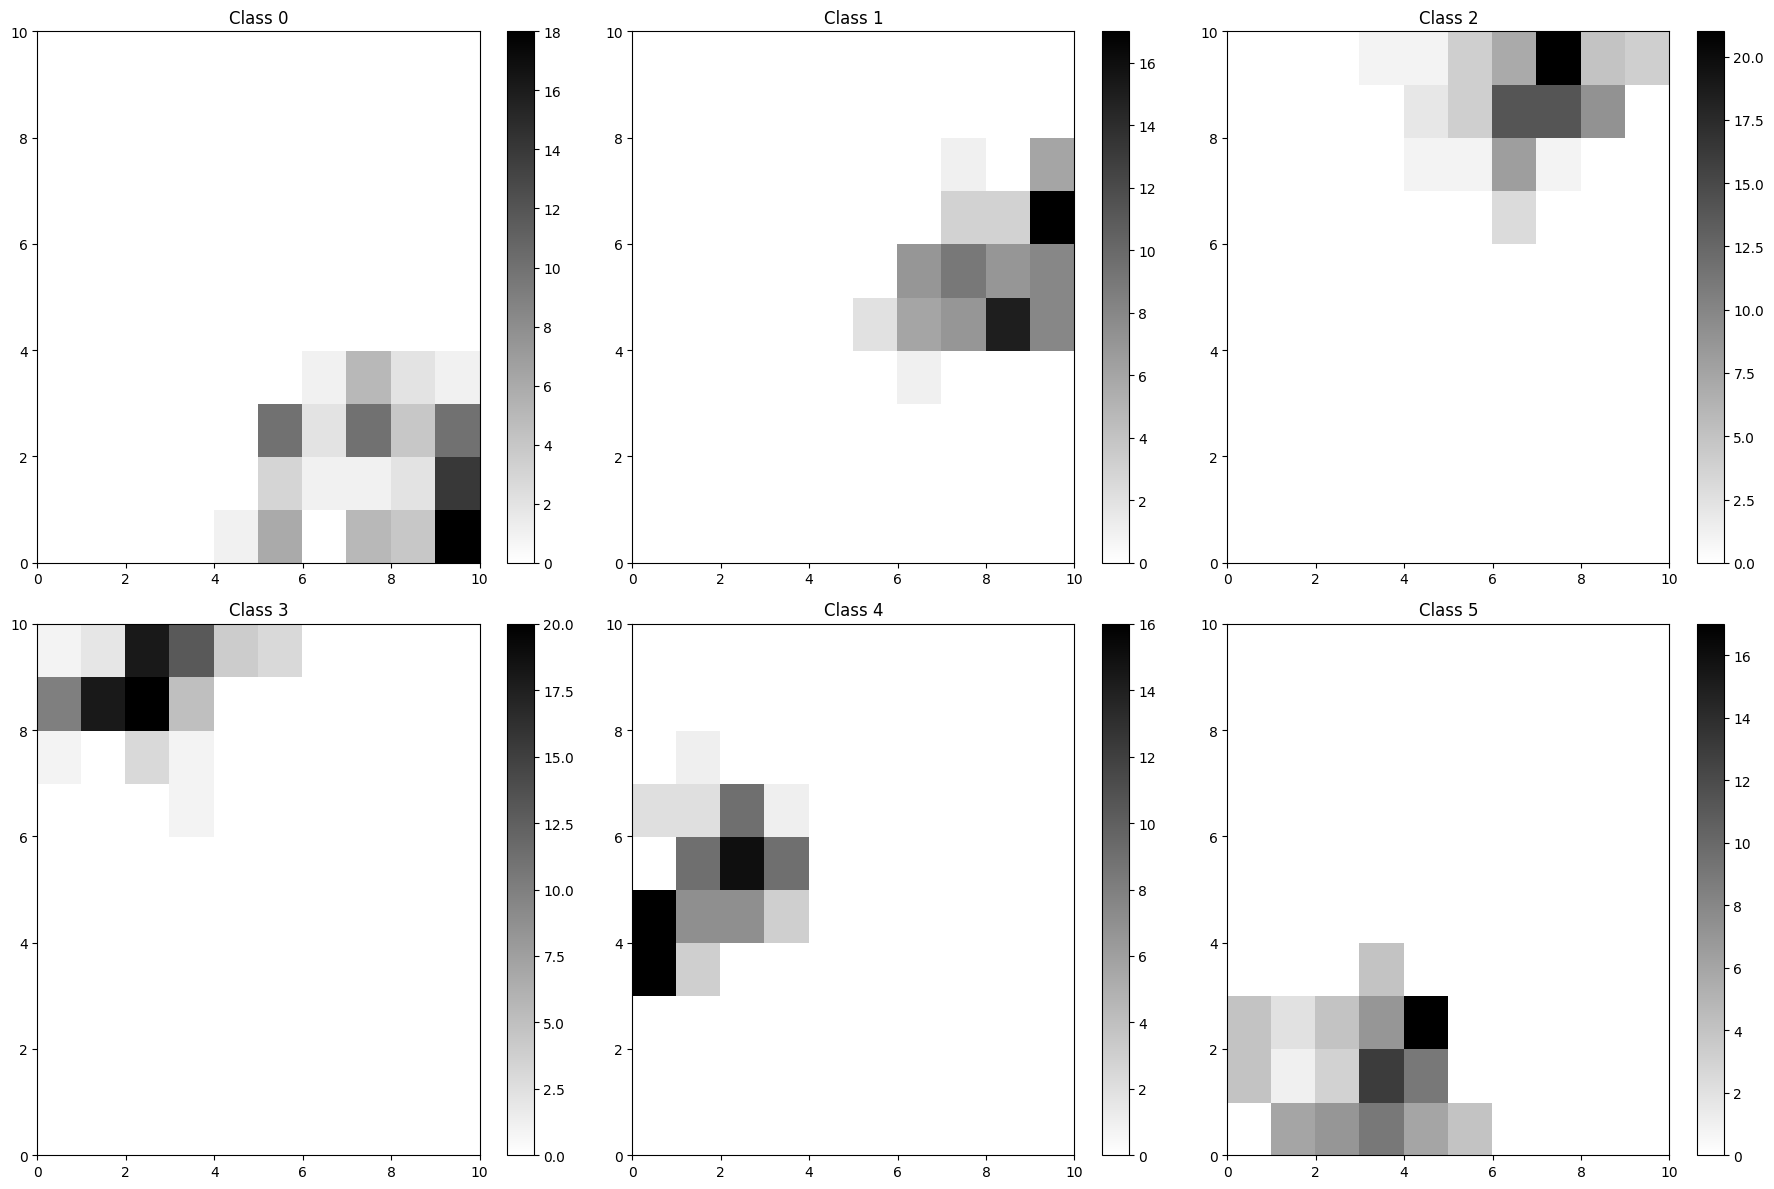

In [180]:
som = SOM(10, 10, 2, nbhd_fun_name='gaussian', nbhd_width=1, lr_decay_rate=1000)
som.fit(X_norm, epochs=100, n_display_epochs=10)
draw_u_matrix(som, X_norm, Y)
plot_som(som, X_norm, Y)
find_n_clusters(som, max_k=10)
draw_neuron_comp(som, X_norm, Y, n_lanbels=6)

Epoch 1/100
Epoch 10/100
Epoch 20/100
Epoch 30/100
Epoch 40/100
Epoch 50/100
Epoch 60/100
Epoch 70/100
Epoch 80/100
Epoch 90/100
Epoch 100/100


C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', len(np.unique(Y)))
C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(bmu[1] + 0.5, bmu[0] + 0.5, marker=markers[Y[i]], c=colors(Y[i]), s=100, label=f'Class {Y[i]}')


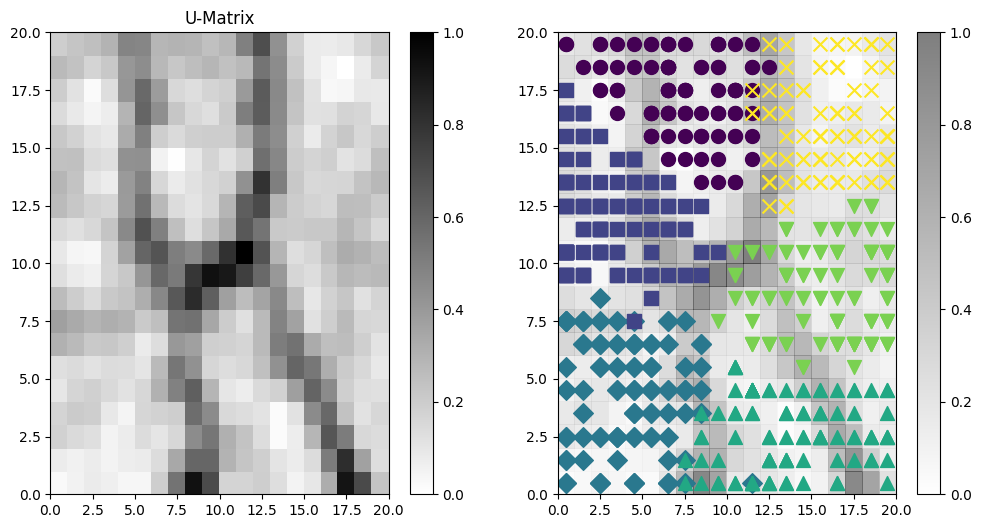

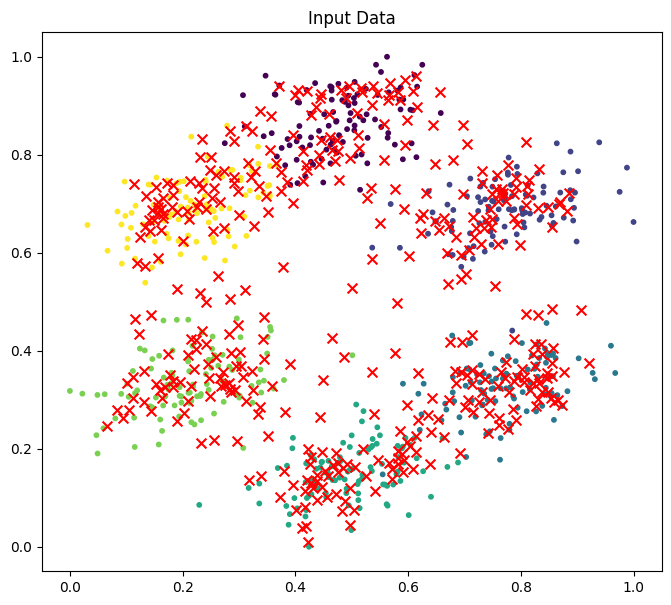

Best number of clusters: 7


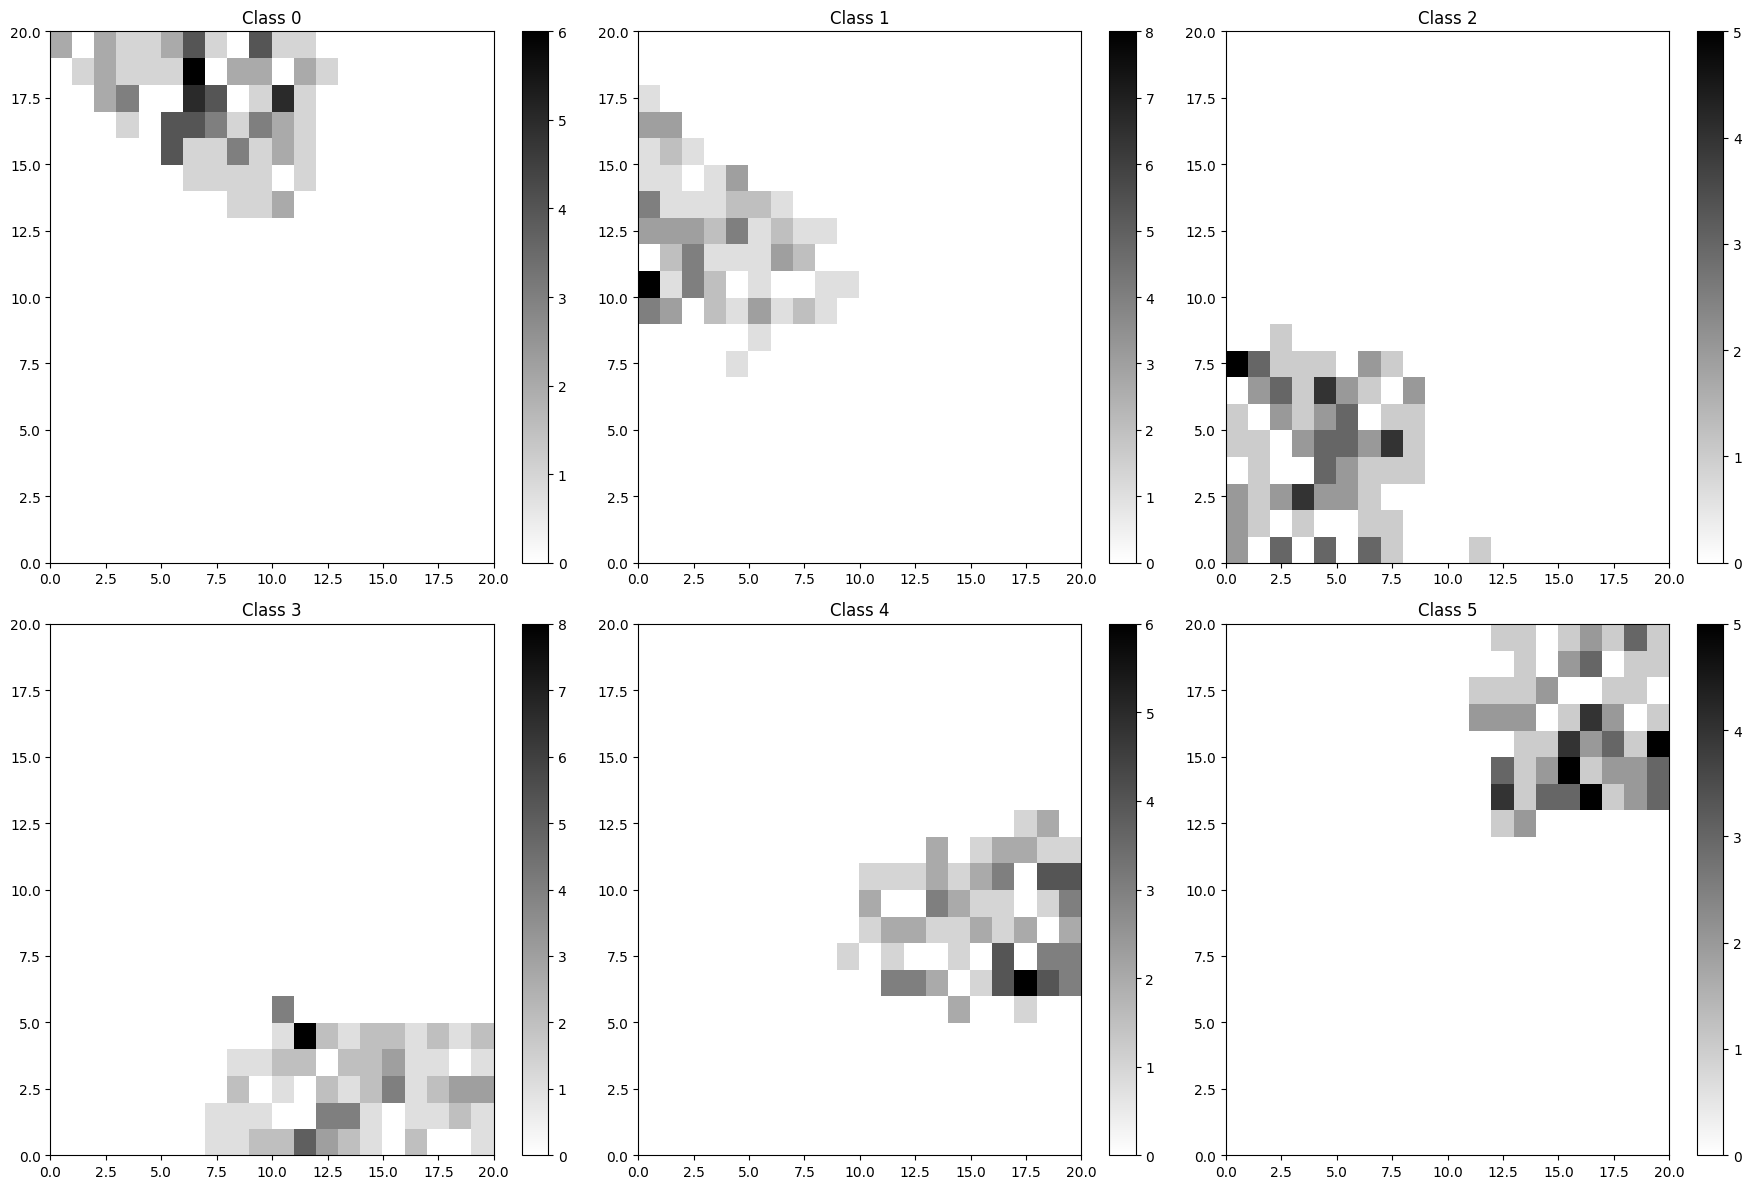

In [181]:
som = SOM(20, 20, 2, nbhd_fun_name='gaussian', nbhd_width=1, lr_decay_rate=1000)
som.fit(X_norm, epochs=100, n_display_epochs=10)
draw_u_matrix(som, X_norm, Y)
plot_som(som, X_norm, Y)
find_n_clusters(som, max_k=10)
draw_neuron_comp(som, X_norm, Y, n_lanbels=6)

# cube

In [182]:
X = pd.read_csv('data/cube.csv')[['x', 'y', 'z']]
Y = pd.read_csv('data/cube.csv')['c']

In [183]:
X_norm, min, max = normalize(X)

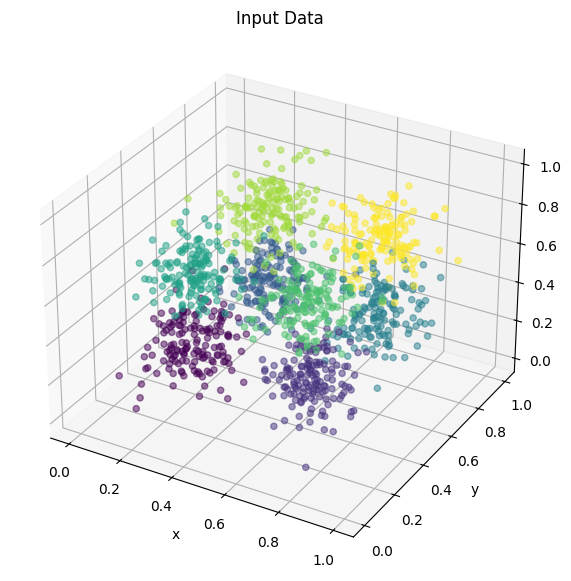

In [184]:
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_norm[:, 0], X_norm[:, 1], X_norm[:, 2], c=Y, cmap='viridis', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Input Data')

plt.show()

Epoch 1/100
Epoch 10/100
Epoch 20/100
Epoch 30/100
Epoch 40/100
Epoch 50/100
Epoch 60/100
Epoch 70/100
Epoch 80/100
Epoch 90/100
Epoch 100/100


C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', len(np.unique(Y)))
C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(bmu[1] + 0.5, bmu[0] + 0.5, marker=markers[Y[i]], c=colors(Y[i]), s=100, label=f'Class {Y[i]}')


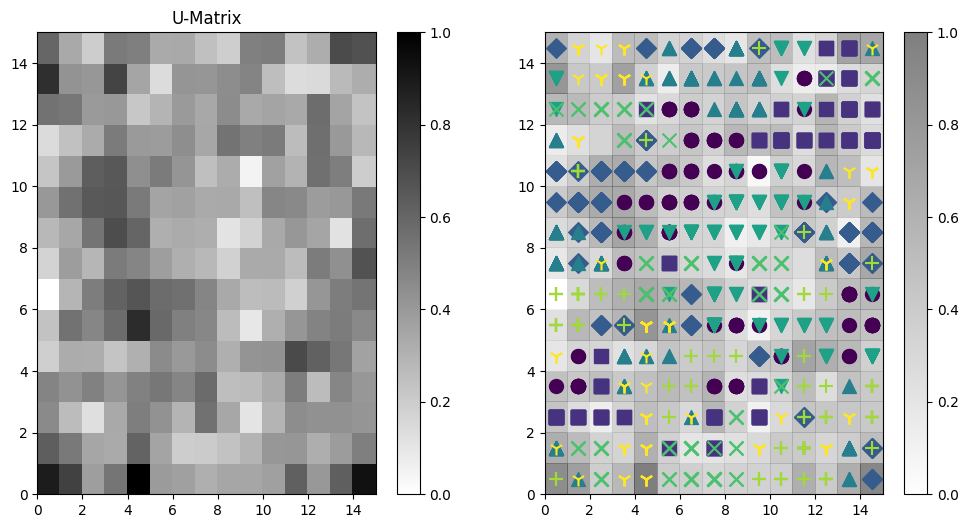

Best number of clusters: 9


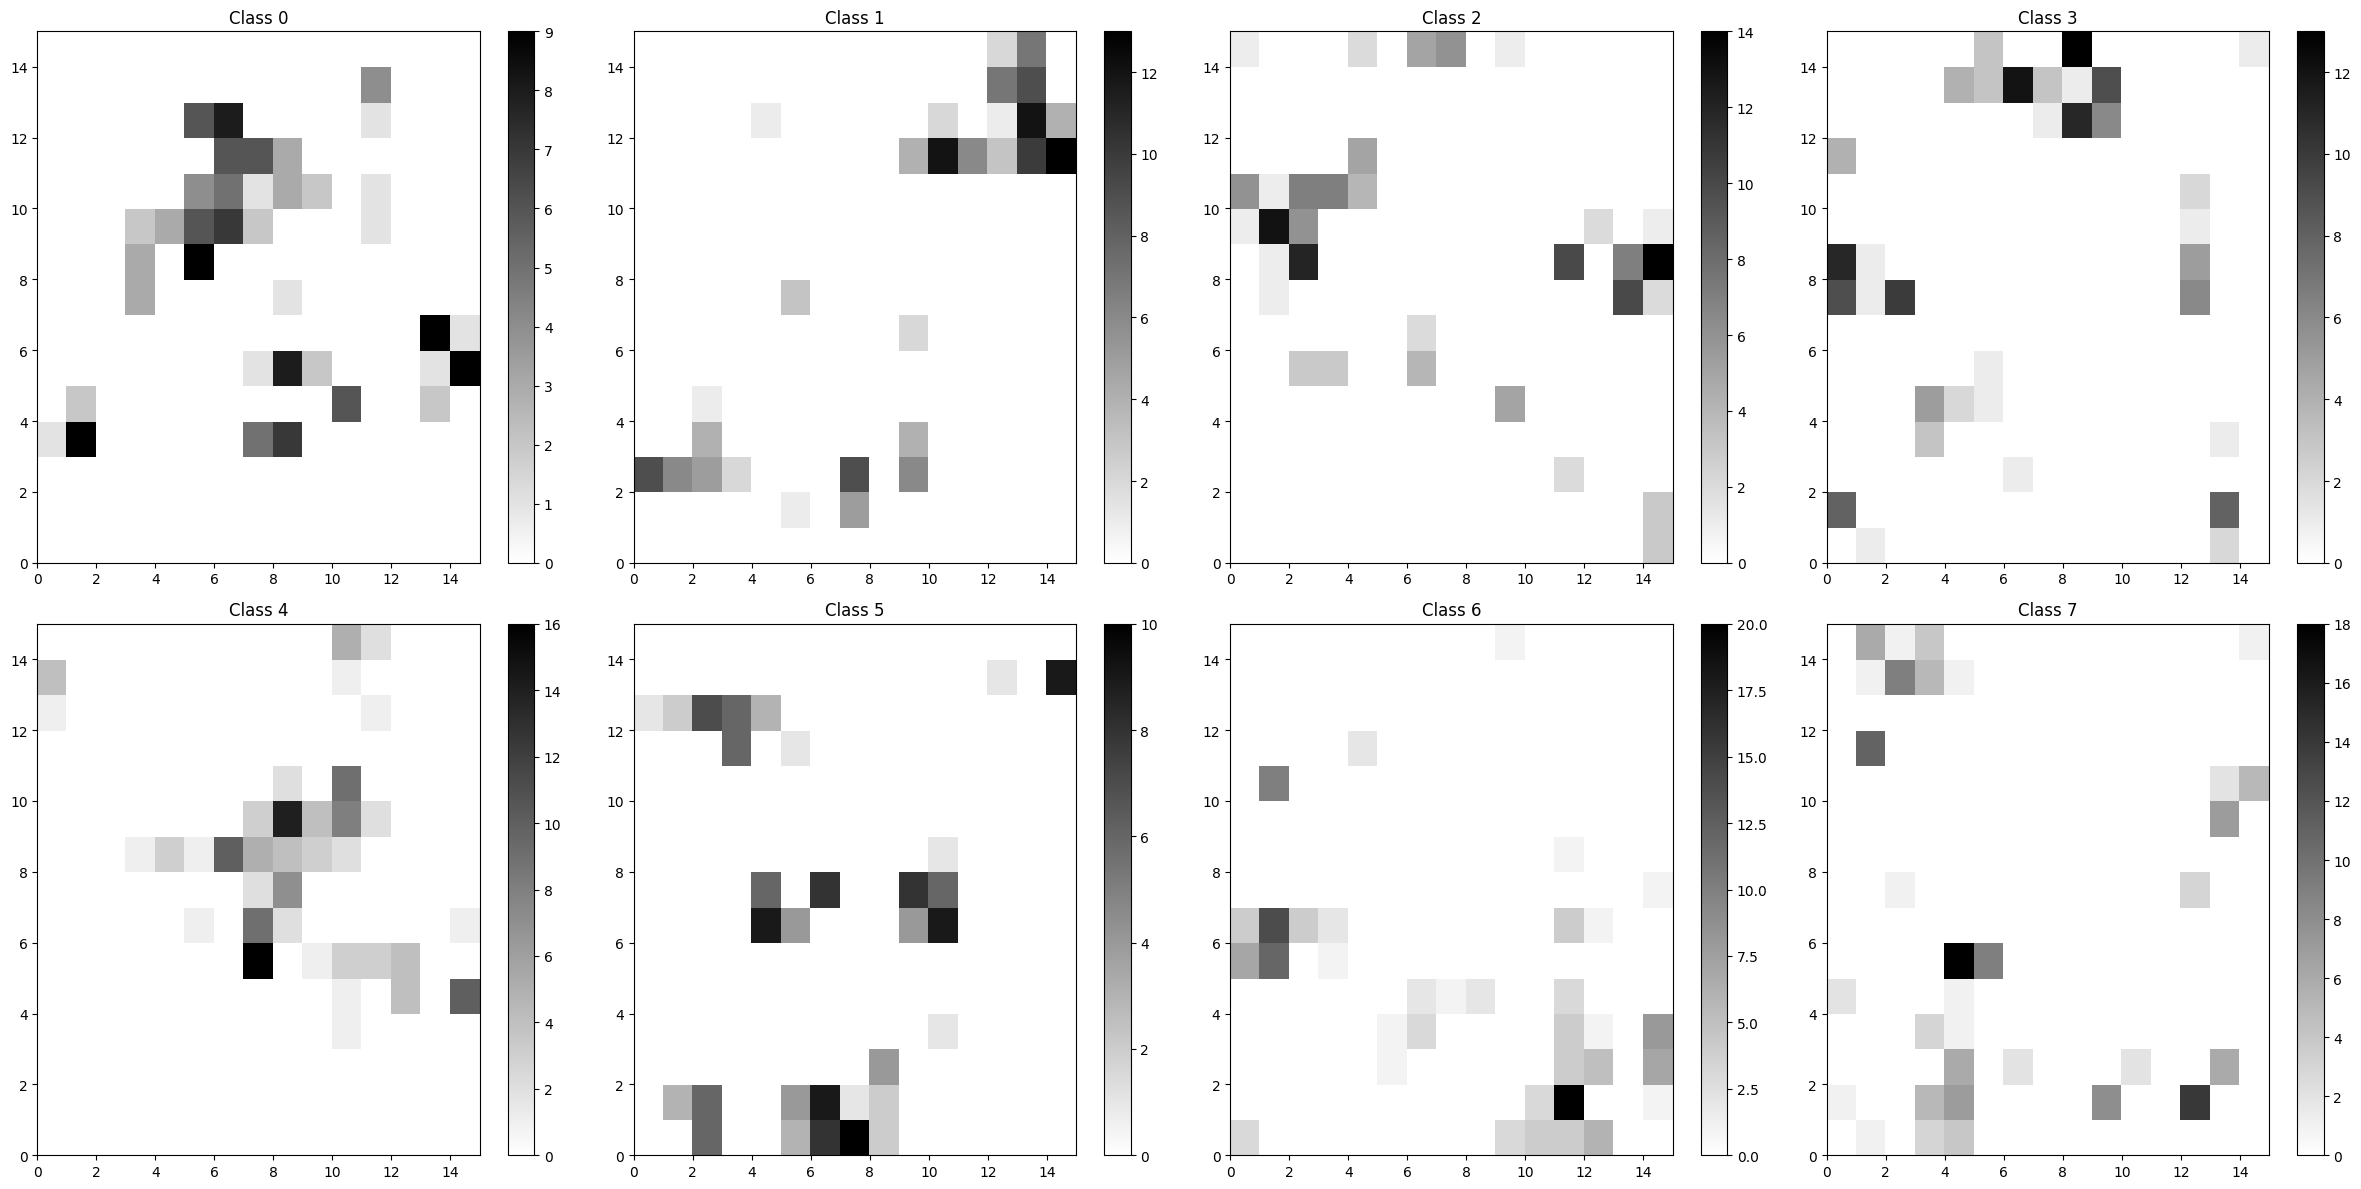

In [188]:
som = SOM(15, 15, 3, nbhd_fun_name='gaussian', nbhd_width=.1, lr_decay_rate=1000)
som.fit(X_norm, epochs=100, n_display_epochs=10)
draw_u_matrix(som, X_norm, Y)
find_n_clusters(som, max_k=12)
draw_neuron_comp(som, X_norm, Y, n_lanbels=8)

Epoch 1/100
Epoch 10/100
Epoch 20/100
Epoch 30/100
Epoch 40/100
Epoch 50/100
Epoch 60/100
Epoch 70/100
Epoch 80/100
Epoch 90/100
Epoch 100/100


C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', len(np.unique(Y)))
C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(bmu[1] + 0.5, bmu[0] + 0.5, marker=markers[Y[i]], c=colors(Y[i]), s=100, label=f'Class {Y[i]}')


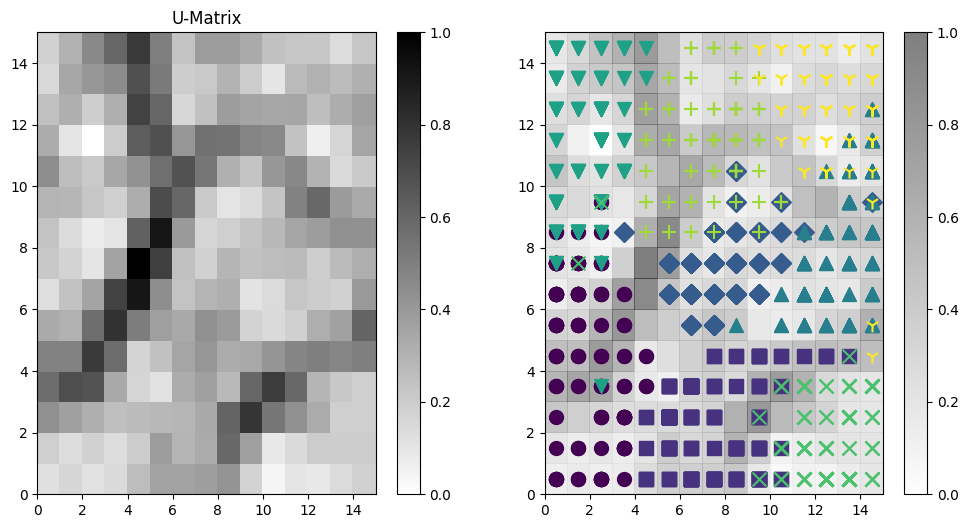

Best number of clusters: 8


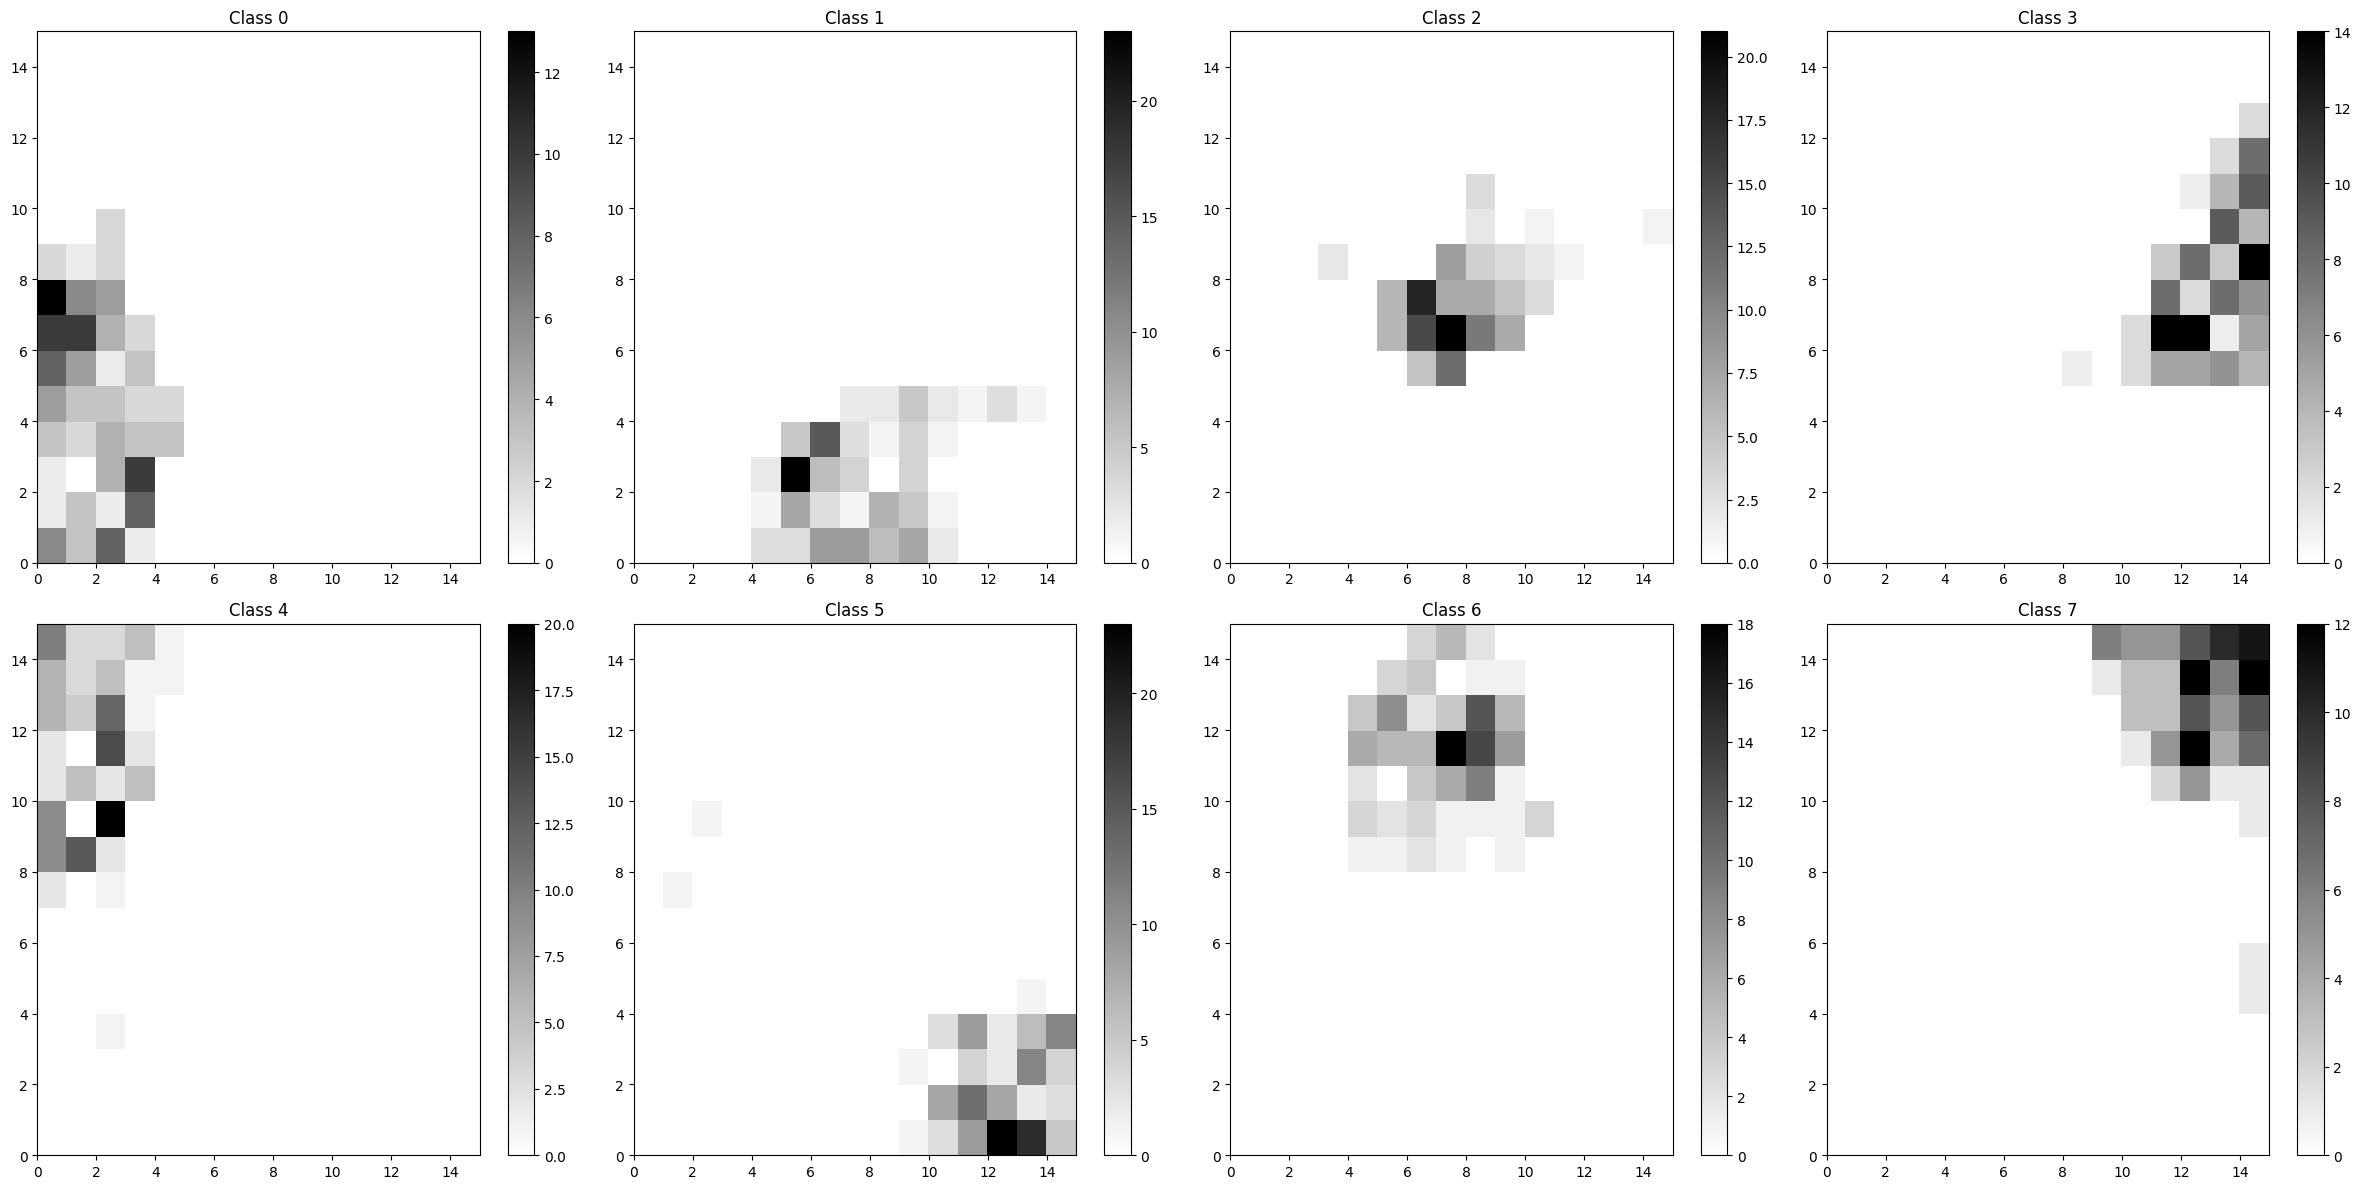

In [189]:
som = SOM(15, 15, 3, nbhd_fun_name='gaussian', nbhd_width=1, lr_decay_rate=1000)
som.fit(X_norm, epochs=100, n_display_epochs=10)
draw_u_matrix(som, X_norm, Y)
find_n_clusters(som, max_k=12)
draw_neuron_comp(som, X_norm, Y, n_lanbels=8)

Epoch 1/100
Epoch 10/100
Epoch 20/100
Epoch 30/100
Epoch 40/100
Epoch 50/100
Epoch 60/100
Epoch 70/100
Epoch 80/100
Epoch 90/100
Epoch 100/100


C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', len(np.unique(Y)))
C:\Users\kuba_\AppData\Local\Temp\ipykernel_13000\2538030763.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(bmu[1] + 0.5, bmu[0] + 0.5, marker=markers[Y[i]], c=colors(Y[i]), s=100, label=f'Class {Y[i]}')


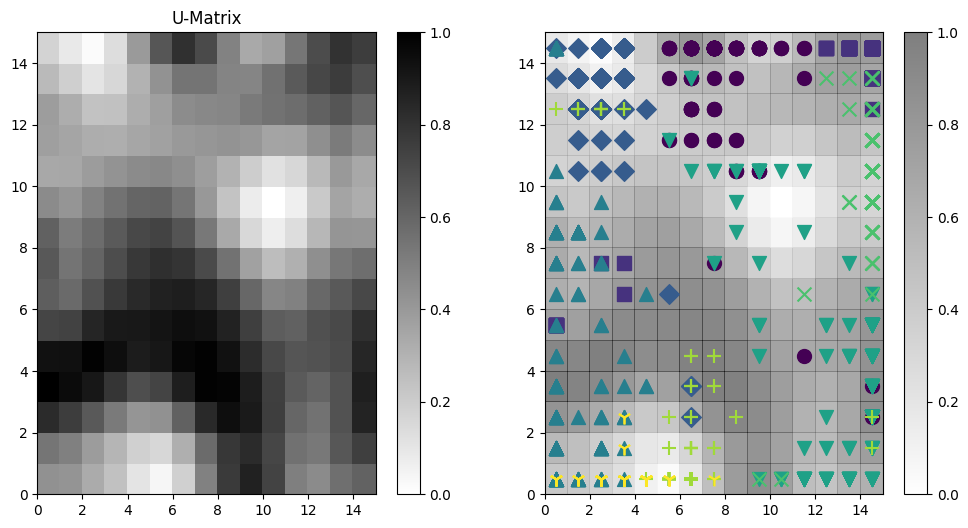

Best number of clusters: 2


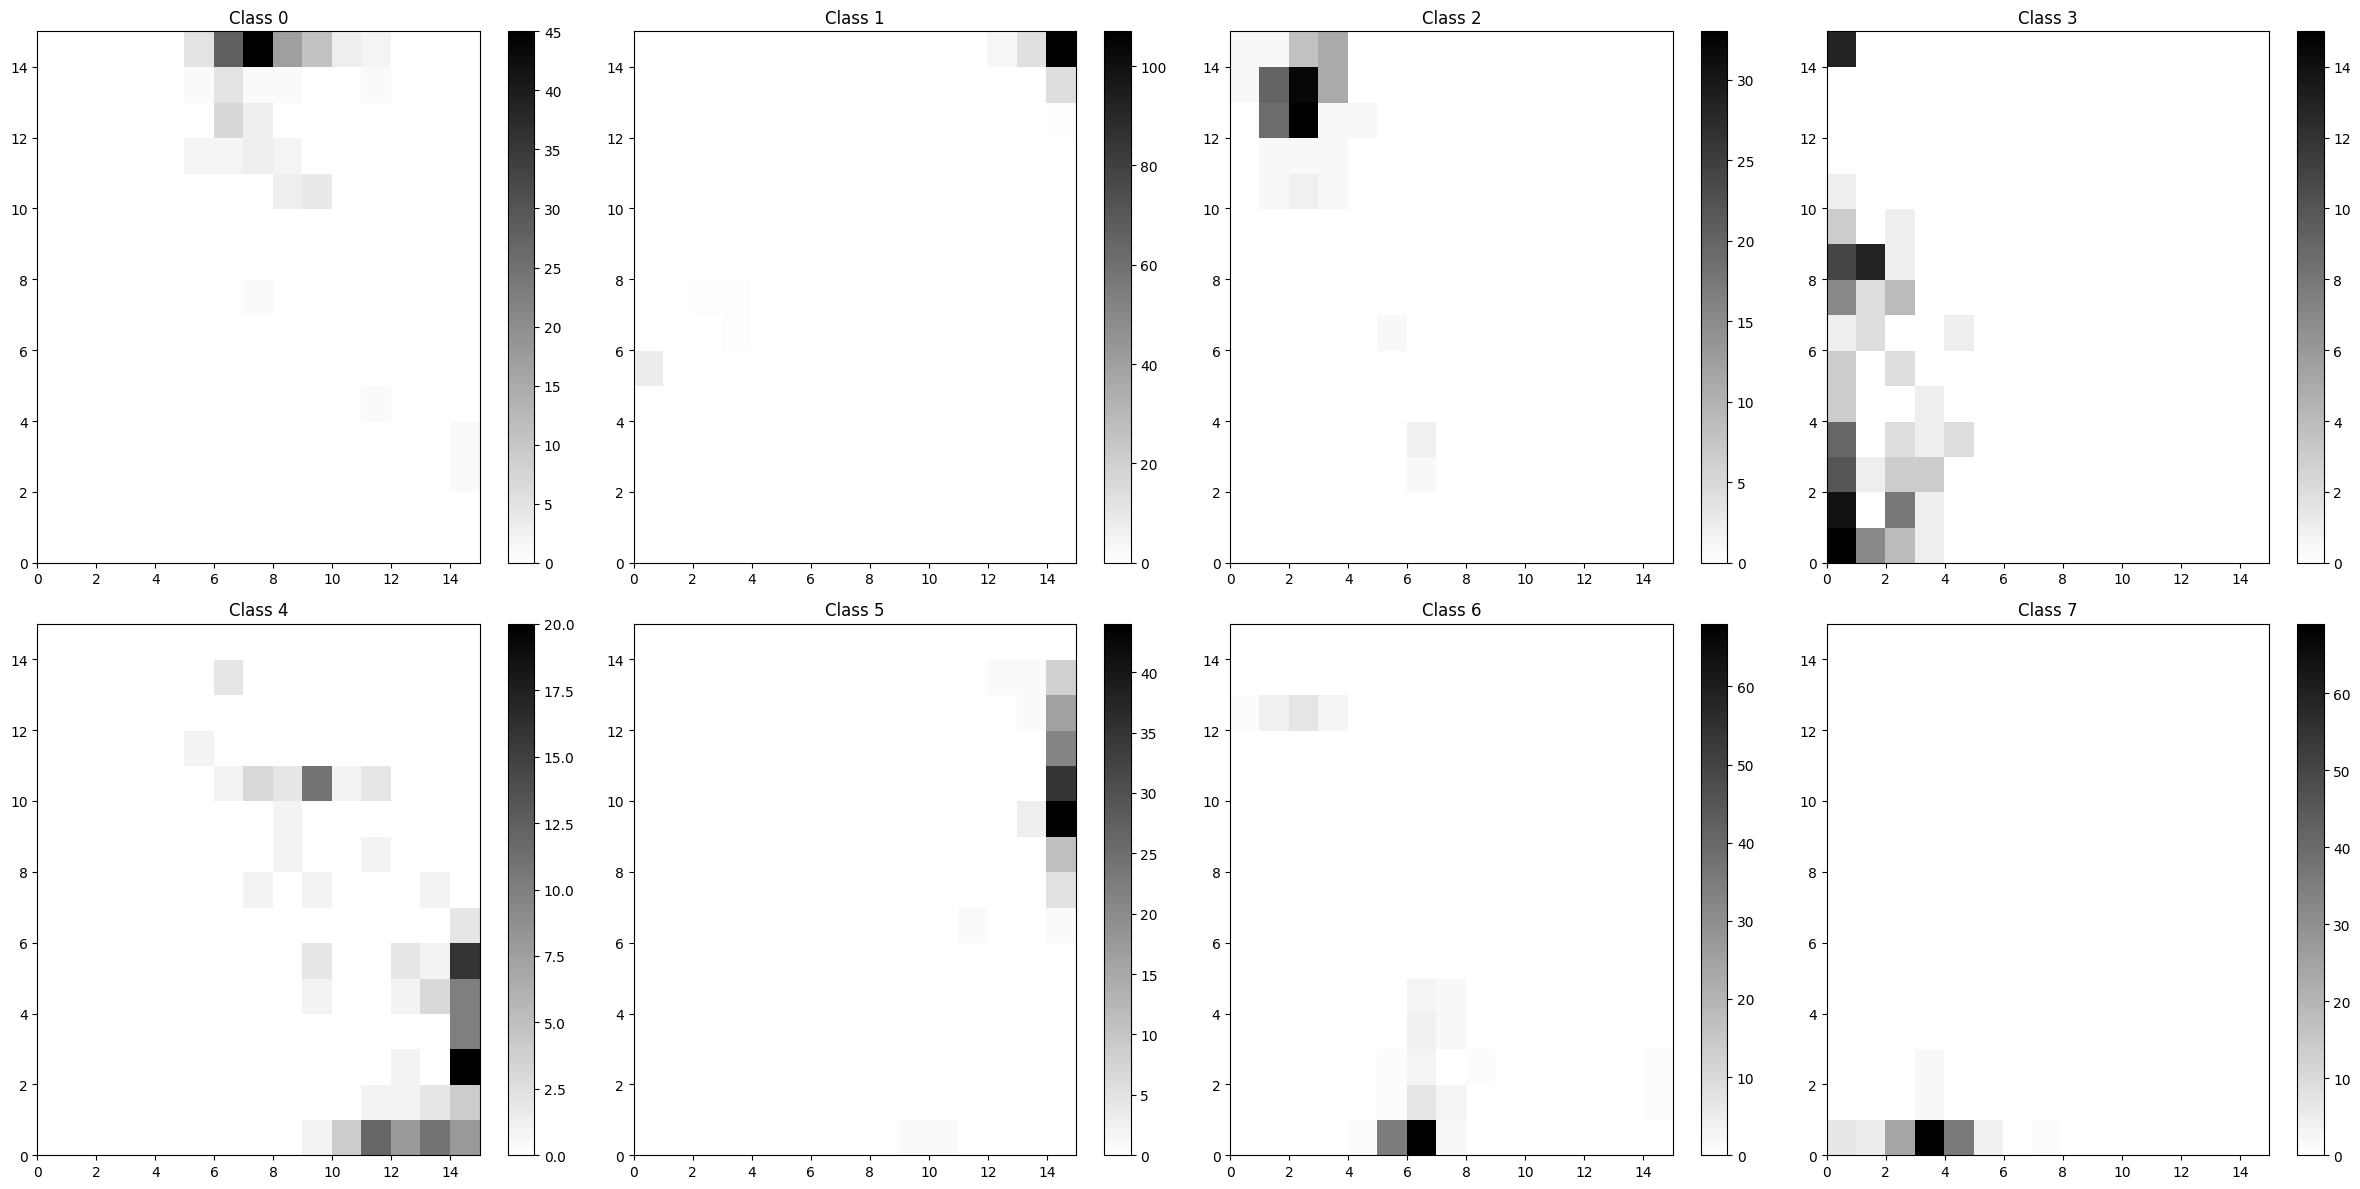

In [190]:
som = SOM(15, 15, 3, nbhd_fun_name='gaussian', nbhd_width=10, lr_decay_rate=1000)
som.fit(X_norm, epochs=100, n_display_epochs=10)
draw_u_matrix(som, X_norm, Y)
find_n_clusters(som, max_k=12)
draw_neuron_comp(som, X_norm, Y, n_lanbels=8)